<a href="https://colab.research.google.com/github/GHILENISABEUR/Django_rest_framework_crud/blob/main/csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Data loaded successfully

📊 Data Overview:
- Time range: 2024-11-18 to 2025-03-05
- 28 unique defect types
- 1512 total records

🔍 Defect Analysis:

Top 15 Defects by Occurrence:
defaut
GRAIN              1604918
FIL                 536270
TROU                429604
BAVURE              199325
PIÈCES REJETÉES     144452
TACHE                93331
GRAIN REJETER        49245
GRAIN POLISH         42210
COULURE              39564
MANQUE PEINTURE      39396
BULLE DAIR           31960
SUBLUMATION          22043
TRACE                21105
PIÈCES TOMBÉES       19229
AGENT GRAS           13132
Name: nb_defauts, dtype: int32


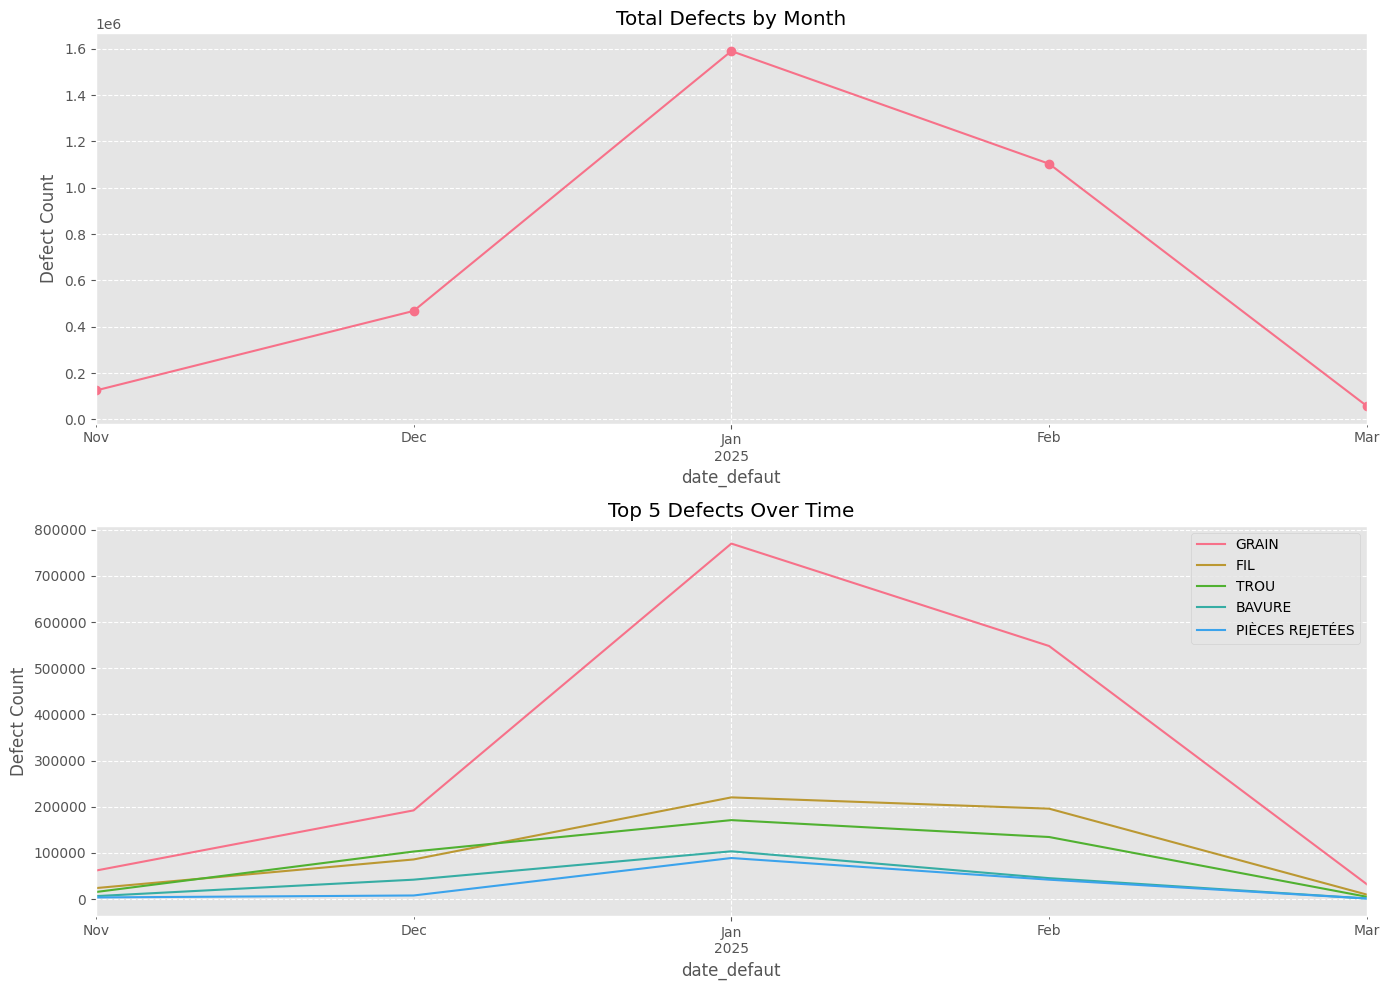


Selected 19 defect types for forecasting
Excluded 9 defect types
Processing: AGENT GRAS
⚠️ Insufficient data points (5), using simple average
Processing: ASPECT RÉCHE
Processing: BAVURE
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
Processing: BRILLANCE NON CONFORME
Processing: BULLE DAIR
Processing: COULURE
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
Processing: FIL
Processing: GRAIN
Processing: GRAIN POLISH
Processing: GRAIN REJETER
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
⚠️ Insufficient data points (5), using simple average
Processing: MANQUE PEINTURE
Processing: MICRO PIQÛRE
Processing: PEAU DORANGE
Processing: PIÈCES REJETÉES
Processing: PIÈCES TOMBÉES
Processing: SUBLUMATION
Process

AttributeError: 'NoneType' object has no attribute 'intercept_'

In [15]:
# 1. Install dependencies

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import warnings
import os
from concurrent.futures import ThreadPoolExecutor

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 3. Enhanced Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    """Load and thoroughly preprocess the defect data"""
    try:
        df = pd.read_csv(
            filepath,
            parse_dates=['date_defaut'],
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
            dtype={'nb_defauts': 'int32'}
        )
    except Exception as e:
        raise ValueError(f"Error loading data: {e}")

    # Data cleaning and standardization
    df['defaut'] = (
        df['defaut']
        .str.strip()
        .str.upper()
        .str.replace(r'\s+', ' ', regex=True)
    )

    # Handle known defect name variations
    defect_name_mapping = {
        'CLIPS CASSE': 'CLIPS CASSE',
        'COULURE': 'COULURE',
        'MANQUE PEINTURE': 'MANQUE PEINTURE',
    }
    df['defaut'] = df['defaut'].map(defect_name_mapping).fillna(df['defaut'])

    # Aggregate duplicates
    df = (
        df.groupby(['date_defaut', 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
        .stack()
        .reset_index(name='nb_defauts')
    )

    # Add time features
    df['year'] = df['date_defaut'].dt.year
    df['month'] = df['date_defaut'].dt.month
    df['quarter'] = df['date_defaut'].dt.quarter

    return df

# Load data
try:
    df = load_and_preprocess_data('/content/defauts_par_piece.csv')
    print("✅ Data loaded successfully\n")
    print("📊 Data Overview:")
    print(f"- Time range: {df['date_defaut'].min().date()} to {df['date_defaut'].max().date()}")
    print(f"- {len(df['defaut'].unique())} unique defect types")
    print(f"- {len(df)} total records\n")
except Exception as e:
    print(f"❌ Error: {e}")
    raise

# 4. Comprehensive Data Analysis
def analyze_data(df):
    """Perform thorough exploratory data analysis"""
    print("🔍 Defect Analysis:")

    defect_counts = df.groupby('defaut')['nb_defauts'].sum().sort_values(ascending=False)
    print("\nTop 15 Defects by Occurrence:")
    print(defect_counts.head(15))

    monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='M'))['nb_defauts'].sum()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    monthly_totals.plot(ax=ax1, title='Total Defects by Month', marker='o')
    ax1.set_ylabel('Defect Count')
    ax1.grid(True, linestyle='--')

    top_defects = defect_counts.head(5).index
    for defect in top_defects:
        df[df['defaut'] == defect].groupby(pd.Grouper(key='date_defaut', freq='M'))['nb_defauts'].sum().plot(
            ax=ax2, label=defect)
    ax2.set_title('Top 5 Defects Over Time')
    ax2.set_ylabel('Defect Count')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    plt.tight_layout()
    plt.show()

    return defect_counts

defect_counts = analyze_data(df)


# 6. Linear Regression Forecasting

def prepare_time_series(df, min_occurrences=5, min_months=3):
    """Prepare time series with more lenient filtering"""
    # Create monthly pivot table
    pivot = (
        df.set_index('date_defaut')
        .groupby([pd.Grouper(freq='M'), 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
    )

    # More lenient filter criteria:
    # 1. Minimum total occurrences reduced to 5
    # 2. Appears in at least 3 months
    # 3. Remove recent activity requirement
    valid_defects = [
        col for col in pivot.columns
        if (pivot[col].sum() >= min_occurrences) and
           (pivot[col].gt(0).sum() >= min_months)
    ]

    if len(valid_defects) == 0:
        print("⚠️ Warning: No defects met the criteria, using all defects with at least 1 occurrence")
        valid_defects = [col for col in pivot.columns if pivot[col].sum() > 0]

    print(f"\nSelected {len(valid_defects)} defect types for forecasting")
    print(f"Excluded {len(pivot.columns) - len(valid_defects)} defect types")

    return pivot[valid_defects]

pivot = prepare_time_series(df)

def create_features(df):
    """Create temporal features for regression"""
    df = df.copy()
    start_date = df['ds'].min()
    df['time_index'] = (df['ds'].dt.year - start_date.year) * 12 + (df['ds'].dt.month - start_date.month) + 1
    months = pd.get_dummies(df['ds'].dt.month, prefix='month', drop_first=True)
    return pd.concat([df[['ds', 'time_index']], months], axis=1)
def forecast_defects(series, periods=13, freq='M'):
    """Robust forecasting with error handling"""
    ts = series.reset_index()
    ts.columns = ['ds', 'y']

    # Need at least 12 months of data for proper train-test split
    if len(ts) < 12:
        print(f"⚠️ Insufficient data points ({len(ts)}), using simple average")
        avg = ts['y'].mean()
        future_dates = pd.date_range(
            start=ts['ds'].max() + pd.DateOffset(months=1),
            periods=periods,
            freq=freq
        )
        return {
            'model': None,
            'forecast': pd.DataFrame({'ds': future_dates, 'yhat': [avg]*periods}),
            'metrics': {'MAE': None, 'MAPE': None}
        }

    try:
        # Rest of your existing forecast_defects function
        ts = create_features(ts)
        train = ts.iloc[:-6]
        test = ts.iloc[-6:]

        features = ['time_index'] + [c for c in ts.columns if c.startswith('month_')]
        X_train, y_train = train[features], train['y']
        X_test, y_test = test[features], test['y']

        model = LinearRegression()
        model.fit(X_train, y_train)

        test_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, test_pred)
        mape = mean_absolute_percentage_error(y_test, test_pred) * 100

        last_date = ts['ds'].max()
        future_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=periods,
            freq=freq
        )
        future_df = create_features(pd.DataFrame({'ds': future_dates}))

        missing_cols = set(features) - set(future_df.columns)
        for c in missing_cols:
            future_df[c] = 0
        future_df = future_df[features]

        forecast = model.predict(future_df)

        return {
            'model': model,
            'forecast': pd.DataFrame({'ds': future_dates, 'yhat': forecast}),
            'metrics': {'MAE': mae, 'MAPE': mape}
        }
    except Exception as e:
        print(f"⚠️ Error in forecasting: {e}, using fallback method")
        avg = ts['y'].mean()
        future_dates = pd.date_range(
            start=ts['ds'].max() + pd.DateOffset(months=1),
            periods=periods,
            freq=freq
        )
        return {
            'model': None,
            'forecast': pd.DataFrame({'ds': future_dates, 'yhat': [avg]*periods}),
            'metrics': {'MAE': None, 'MAPE': None}
        }

# 7. Parallel Processing
def run_forecasts(pivot):
    """Run forecasts in parallel"""
    results = {}

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {}
        for dtype in pivot.columns:
            print(f"Processing: {dtype}")
            futures[dtype] = executor.submit(forecast_defects, pivot[dtype])

        for dtype, future in futures.items():
            try:
                results[dtype] = future.result()
            except Exception as e:
                print(f"Error processing {dtype}: {e}")

    return results

results = run_forecasts(pivot)

# 8. Forecast Consolidation
def create_enhanced_forecast_df(results, start_date='2025-06-01', end_date='2026-06-30'):
    """Create comprehensive forecast DataFrame"""
    forecast_data = []
    metrics_data = []
    coefficients_data = []

    for dtype, data in results.items():
        # Forecast data
        temp_df = data['forecast'].copy()
        temp_df['defect_type'] = dtype
        forecast_data.append(temp_df)

        # Metrics
        metrics_row = {
            'defect_type': dtype,
            'MAE': data['metrics']['MAE'],
            'MAPE': data['metrics']['MAPE'],
            'intercept': data['model'].intercept_
        }
        metrics_data.append(metrics_row)

        # Coefficients
        for feature, coef in data['coefficients'].items():
            coefficients_data.append({
                'defect_type': dtype,
                'feature': feature,
                'coefficient': coef
            })

    # Combine data
    forecast_df = pd.concat(forecast_data)
    forecast_period = forecast_df[
        (forecast_df['ds'] >= start_date) &
        (forecast_df['ds'] <= end_date)
    ]

    point_forecast = forecast_period.pivot(index='ds', columns='defect_type', values='yhat')
    metrics_df = pd.DataFrame(metrics_data)
    coefficients_df = pd.DataFrame(coefficients_data)

    return {
        'point_forecast': point_forecast,
        'metrics': metrics_df,
        'coefficients': coefficients_df
    }

forecast_data = create_enhanced_forecast_df(results)

# 9. Enhanced Visualizations
def create_visualizations(forecast_data, top_n=10):
    """Create comprehensive visualizations"""
    point_forecast = forecast_data['point_forecast']
    metrics_df = forecast_data['metrics']
    coefficients_df = forecast_data['coefficients']

    # Calculate total defects by type
    total_defects = point_forecast.sum().sort_values(ascending=False)
    top_defects = total_defects.head(top_n).index

    # 1. Interactive Plotly Visualization
    fig1 = px.line(
        point_forecast[top_defects].reset_index().melt(id_vars='ds', var_name='Defect', value_name='Count'),
        x='ds',
        y='Count',
        color='Defect',
        title=f'Top {top_n} Defect Forecasts (Interactive)',
        labels={'ds': 'Date', 'Count': 'Defect Count'},
        template='plotly_white'
    )
    fig1.show()

    # 2. Static Visualizations
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Top defects line plot
    for dtype in top_defects:
        ax1.plot(
            point_forecast.index,
            point_forecast[dtype],
            label=dtype,
            linewidth=2
        )
    ax1.set_title(f'Top {top_n} Defect Forecasts', fontsize=14)
    ax1.set_ylabel('Defect Count', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--')
    ax1.set_xticks(point_forecast.index)
    ax1.set_xticklabels(point_forecast.index.strftime('%b %Y'), rotation=45)

    # Forecast accuracy metrics
    metrics_df.sort_values('MAPE', ascending=True).head(15).plot(
        x='defect_type',
        y='MAPE',
        kind='barh',
        ax=ax2,
        title='Top 15 Most Accurate Forecasts (Lowest MAPE)',
        legend=False
    )
    ax2.set_xlabel('Mean Absolute Percentage Error (%)')
    ax2.grid(True, axis='x', linestyle='--')

    # Monthly total defects
    point_forecast.sum(axis=1).plot(
        kind='bar',
        ax=ax3,
        title='Total Defects by Month',
        color='teal'
    )
    ax3.set_ylabel('Total Defects')
    ax3.grid(True, axis='y', linestyle='--')
    ax3.set_xticklabels(point_forecast.index.strftime('%b %Y'), rotation=45)

    # Model coefficients analysis
    top_coeff = coefficients_df[coefficients_df['feature'] == 'time_index'].sort_values('coefficient', ascending=False).head(10)
    top_coeff.plot(
        x='defect_type',
        y='coefficient',
        kind='barh',
        ax=ax4,
        title='Top 10 Defects by Trend Strength (Time Coefficient)',
        legend=False,
        color='purple'
    )
    ax4.set_xlabel('Trend Coefficient')
    ax4.grid(True, axis='x', linestyle='--')

    plt.suptitle('Comprehensive Defect Forecast Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('/content/defect_forecast_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

create_visualizations(forecast_data)

# 10. Save Enhanced Results
def save_enhanced_results(forecast_data, path):
    """Save all forecast results and metrics"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f"{path}/defect_forecast_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)

    # Save forecast data
    forecast_data['point_forecast'].to_csv(f"{save_dir}/point_forecasts.csv")
    forecast_data['metrics'].to_csv(f"{save_dir}/forecast_metrics.csv", index=False)
    forecast_data['coefficients'].to_csv(f"{save_dir}/model_coefficients.csv", index=False)

    # Save interactive visualization
    top_defects = forecast_data['point_forecast'].sum().sort_values(ascending=False).head(10).index
    fig = px.line(
        forecast_data['point_forecast'][top_defects].reset_index().melt(id_vars='ds', var_name='Defect', value_name='Count'),
        x='ds',
        y='Count',
        color='Defect',
        title='Top 10 Defect Forecasts'
    )
    fig.write_html(f"{save_dir}/interactive_forecast.html")

    print(f"📁 All results saved to: {save_dir}")

save_enhanced_results(forecast_data, '/content')

<ipython-input-7-3cb25df95480>:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


✅ Data loaded successfully
Time range: 2024-11-18 to 2025-03-05
28 unique defect types

🔍 Analysis Results:
- Total defects: 28
- Defects with sufficient data (≥6 months): 0
- Defects needing more data: 28



<ipython-input-7-3cb25df95480>:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'defaut'])['nb_defauts']


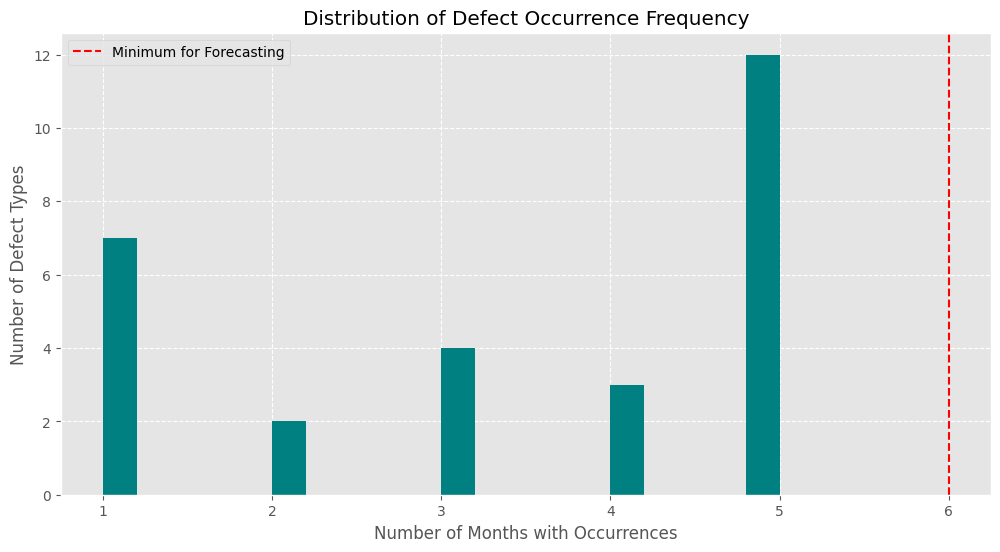

📊 Alternative Analysis Approaches:
1. Defect Concentration Analysis
2. Monthly Trend Analysis
3. Defect Co-occurrence Patterns



<ipython-input-7-3cb25df95480>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_defects, x='Total', y='Defect', palette='viridis')


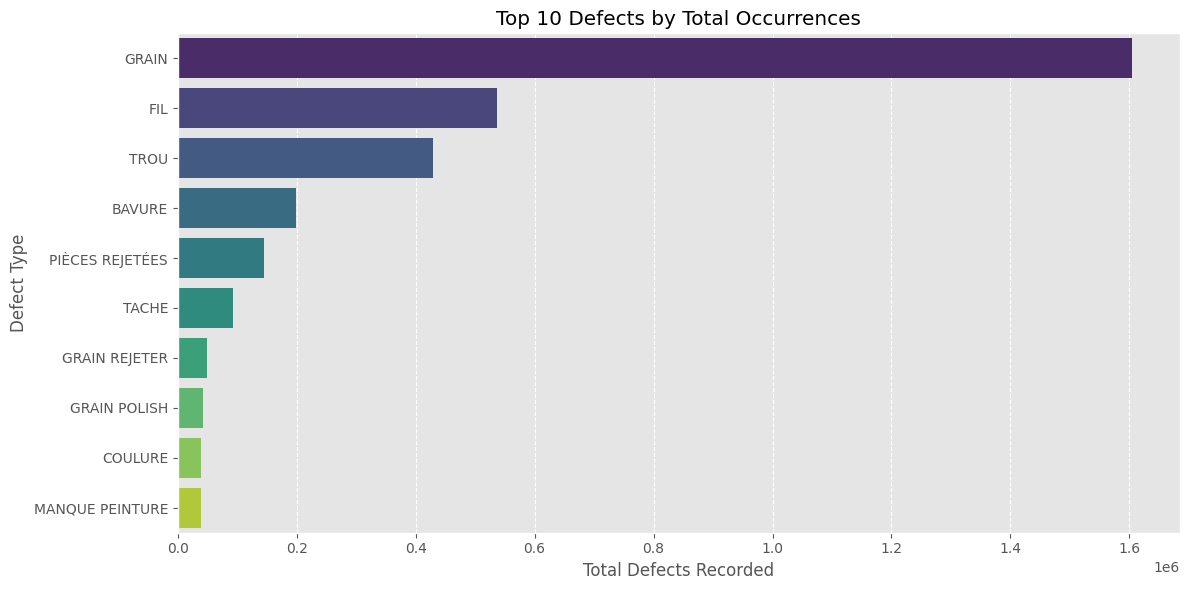

<ipython-input-7-3cb25df95480>:142: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='M'))['nb_defauts'].sum()


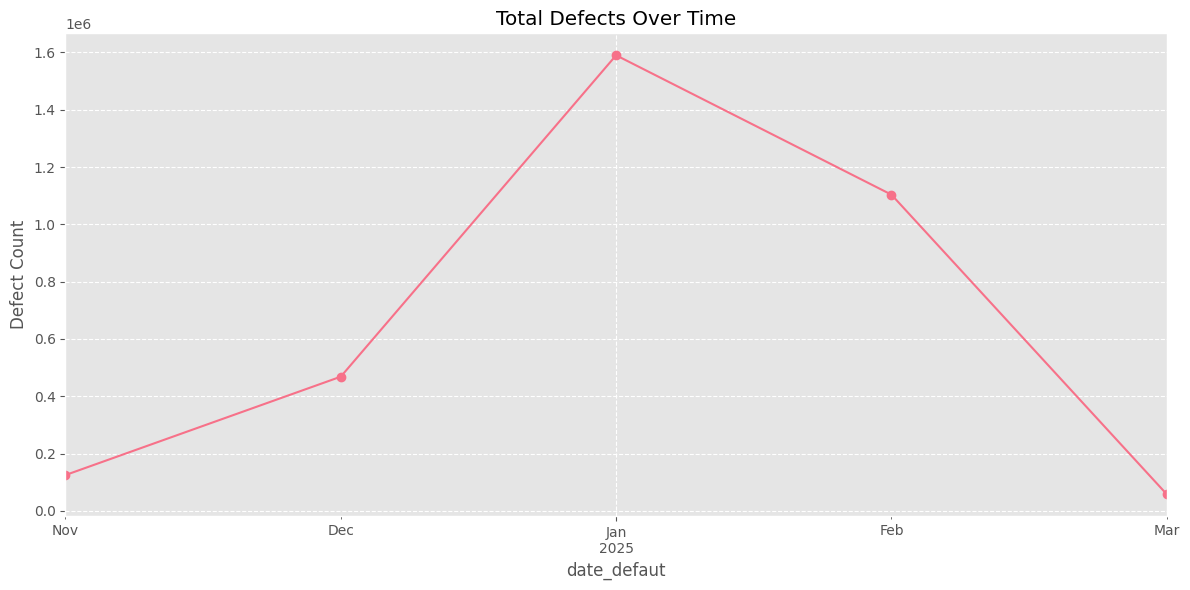

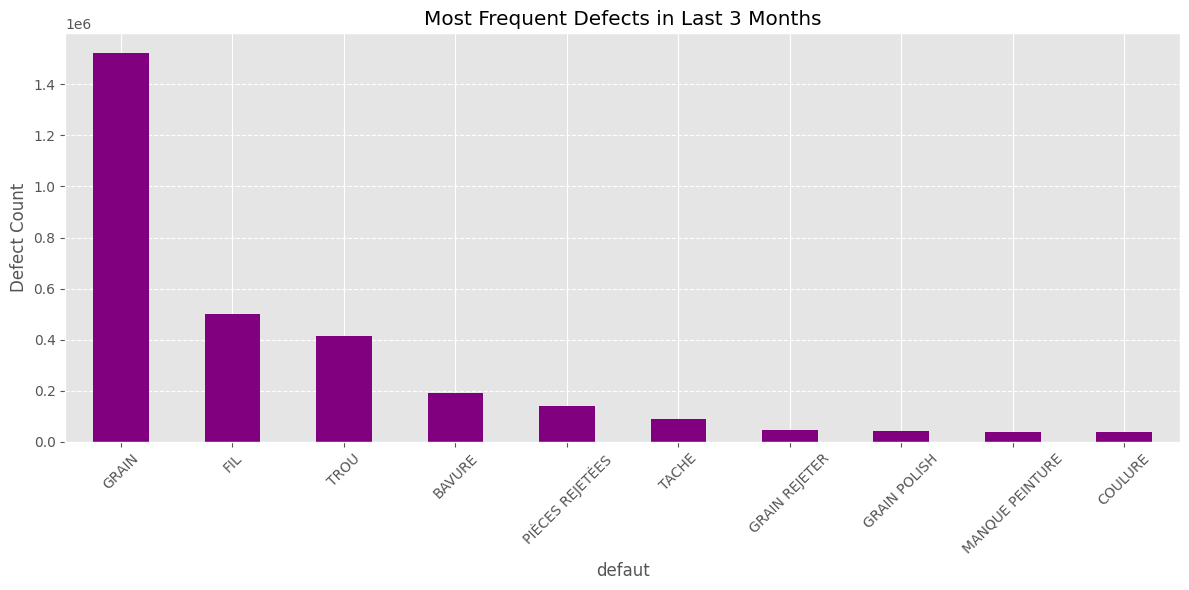


🔧 Recommendations for Better Forecasting:
1. Continue collecting data - most defects need more occurrence months
2. Focus on these defects that are closest to having enough data:
                Defect  Months_Recorded Last_Occurrence
                 GRAIN                5         2025-03
                   FIL                5         2025-03
                  TROU                5         2025-03
                BAVURE                5         2025-03
       PIÈCES REJETÉES                5         2025-03
                 TACHE                5         2025-03
         GRAIN REJETER                4         2025-02
          GRAIN POLISH                5         2025-03
               COULURE                5         2025-03
       MANQUE PEINTURE                5         2025-03
            BULLE DAIR                4         2025-02
           SUBLUMATION                3         2025-02
                 TRACE                5         2025-03
        PIÈCES TOMBÉES              

In [7]:
# 1. Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn plotly --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime
import os

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 3. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    """Load and clean the defect data"""
    try:
        df = pd.read_csv(
            filepath,
            parse_dates=['date_defaut'],
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
            dtype={'nb_defauts': 'int32'}
        )

        # Clean defect names
        df['defaut'] = (
            df['defaut']
            .str.strip()
            .str.upper()
            .str.replace(r'\s+', ' ', regex=True)
        )

        # Standardize defect names
        defect_name_mapping = {
            'CLIPS CASSE': 'CLIPS CASSE',
            'COULURE': 'COULURE',
            'MANQUE PEINTURE': 'MANQUE PEINTURE',
        }
        df['defaut'] = df['defaut'].map(defect_name_mapping).fillna(df['defaut'])

        # Aggregate by date and defect type
        df = (
            df.groupby(['date_defaut', 'defaut'])['nb_defauts']
            .sum()
            .unstack(fill_value=0)
            .stack()
            .reset_index(name='nb_defauts')
        )

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load data
try:
    df = load_and_preprocess_data('/content/defauts_par_piece.csv')
    print("✅ Data loaded successfully")
    print(f"Time range: {df['date_defaut'].min().date()} to {df['date_defaut'].max().date()}")
    print(f"{len(df['defaut'].unique())} unique defect types\n")
except Exception as e:
    print(f"❌ Critical error: {e}")
    raise

# 4. Data Analysis with Defect Frequency Report
def analyze_defect_frequency(df):
    """Generate detailed report on defect frequency patterns"""
    # Monthly pivot table
    monthly_pivot = (
        df.set_index('date_defaut')
        .groupby([pd.Grouper(freq='M'), 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
    )

    # Calculate statistics for each defect
    defect_stats = []
    for defect in monthly_pivot.columns:
        defect_series = monthly_pivot[defect]
        active_months = defect_series[defect_series > 0]
        defect_stats.append({
            'Defect': defect,
            'Total': defect_series.sum(),
            'Months_Recorded': len(active_months),
            'First_Occurrence': active_months.index.min().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Last_Occurrence': active_months.index.max().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Average_Per_Month': active_months.mean() if len(active_months) > 0 else 0,
            'Suitable_For_Forecast': 'Yes' if len(active_months) >= 6 else 'No'
        })

    stats_df = pd.DataFrame(defect_stats).sort_values('Total', ascending=False)

    # Print summary
    suitable_defects = stats_df[stats_df['Suitable_For_Forecast'] == 'Yes']
    print(f"🔍 Analysis Results:")
    print(f"- Total defects: {len(stats_df)}")
    print(f"- Defects with sufficient data (≥6 months): {len(suitable_defects)}")
    print(f"- Defects needing more data: {len(stats_df) - len(suitable_defects)}\n")

    # Plot defect frequency
    plt.figure(figsize=(12, 6))
    stats_df['Months_Recorded'].hist(bins=20, color='teal')
    plt.axvline(x=6, color='red', linestyle='--', label='Minimum for Forecasting')
    plt.title('Distribution of Defect Occurrence Frequency')
    plt.xlabel('Number of Months with Occurrences')
    plt.ylabel('Number of Defect Types')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

    return stats_df

stats_df = analyze_defect_frequency(df)

# 5. Alternative Analysis Approach
def perform_alternative_analysis(df, stats_df):
    """Perform alternative analysis when forecasting isn't possible"""
    print("📊 Alternative Analysis Approaches:")
    print("1. Defect Concentration Analysis")
    print("2. Monthly Trend Analysis")
    print("3. Defect Co-occurrence Patterns\n")

    # 1. Defect Concentration
    top_defects = stats_df.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_defects, x='Total', y='Defect', palette='viridis')
    plt.title('Top 10 Defects by Total Occurrences')
    plt.xlabel('Total Defects Recorded')
    plt.ylabel('Defect Type')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    # 2. Monthly Trends
    monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='M'))['nb_defauts'].sum()
    plt.figure(figsize=(12, 6))
    monthly_totals.plot(marker='o')
    plt.title('Total Defects Over Time')
    plt.ylabel('Defect Count')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

    # 3. Recent Defects
    recent_defects = df[df['date_defaut'] >= (df['date_defaut'].max() - pd.DateOffset(months=3))]
    recent_counts = recent_defects.groupby('defaut')['nb_defauts'].sum().sort_values(ascending=False)

    if not recent_counts.empty:
        plt.figure(figsize=(12, 6))
        recent_counts.head(10).plot(kind='bar', color='purple')
        plt.title('Most Frequent Defects in Last 3 Months')
        plt.ylabel('Defect Count')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No defect data in the last 3 months")

perform_alternative_analysis(df, stats_df)

# 6. Data Quality Recommendations
def provide_recommendations(stats_df):
    """Provide recommendations for improving data quality"""
    print("\n🔧 Recommendations for Better Forecasting:")
    print("1. Continue collecting data - most defects need more occurrence months")
    print("2. Focus on these defects that are closest to having enough data:")

    # Find defects with 3-5 months of data
    promising_defects = stats_df[(stats_df['Months_Recorded'] >= 3) &
                               (stats_df['Months_Recorded'] < 6)]

    if not promising_defects.empty:
        print(promising_defects[['Defect', 'Months_Recorded', 'Last_Occurrence']].to_string(index=False))
    else:
        print("(No defects currently with 3-5 months of data)")

    print("\n3. Verify data collection process for defects that appear rarely")
    print("4. Consider merging similar defect categories if appropriate")

provide_recommendations(stats_df)

# 7. Save Analysis Results
def save_analysis_results(stats_df, path='/content'):
    """Save all analysis results"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f"{path}/defect_analysis_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)

    # Save data
    stats_df.to_csv(f"{save_dir}/defect_stats.csv", index=False)

    print(f"\n📁 Analysis results saved to: {save_dir}")

save_analysis_results(stats_df)

#finalversion


<ipython-input-11-fe999ed6fe51>:23: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


✅ Data loaded successfully
Time range: 2024-11-18 to 2025-03-05
28 unique defect types

🔍 Analysis Results:
- Total defects: 28
- Defects with sufficient data (≥3 months): 19
- Defects needing more data: 9



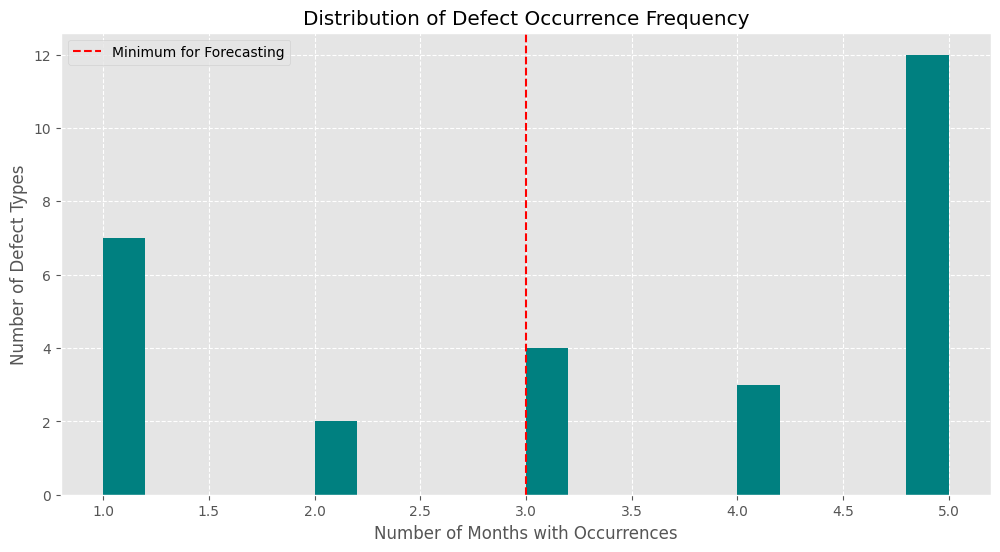

📊 Alternative Analysis Approaches:
1. Defect Concentration Analysis
2. Monthly Trend Analysis
3. Defect Co-occurrence Patterns



<ipython-input-11-fe999ed6fe51>:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_defects, x='Total', y='Defect', palette='viridis')


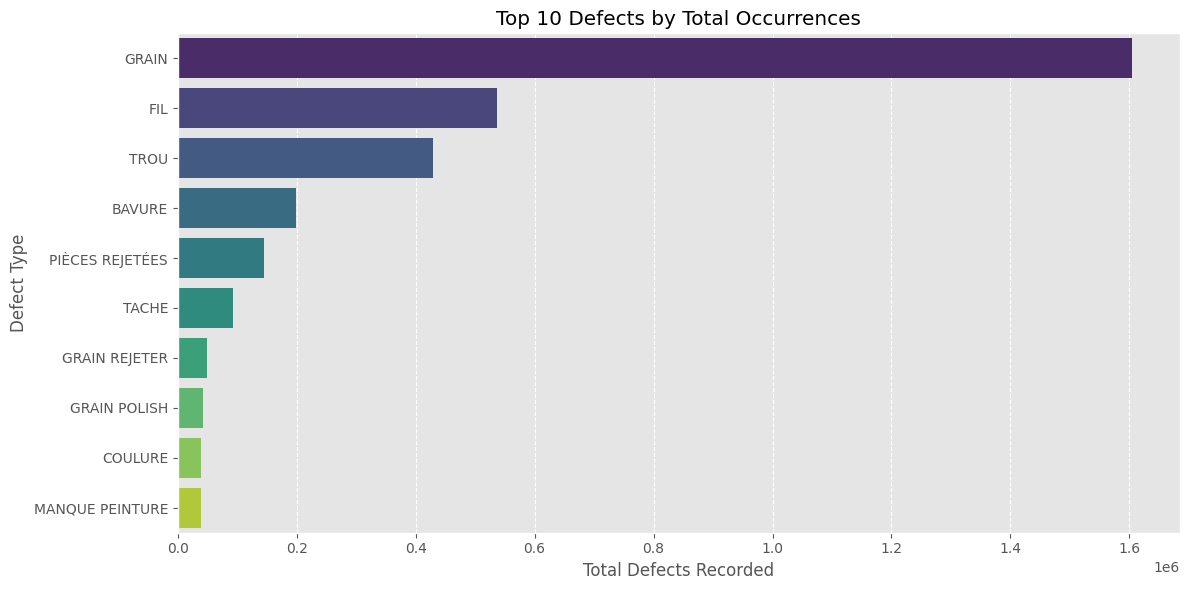

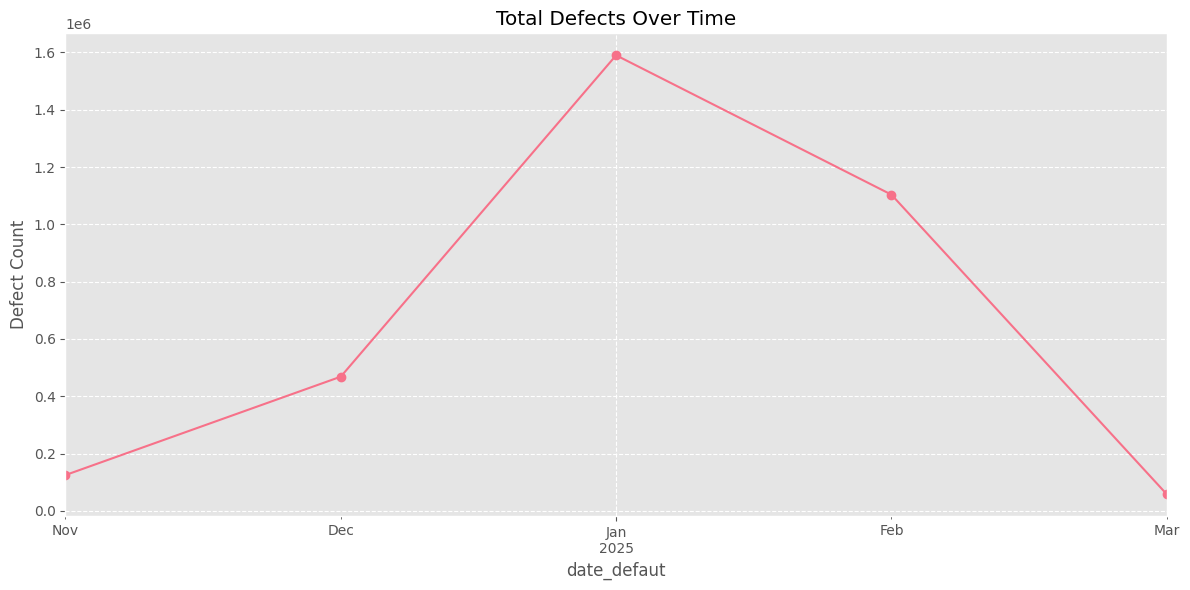

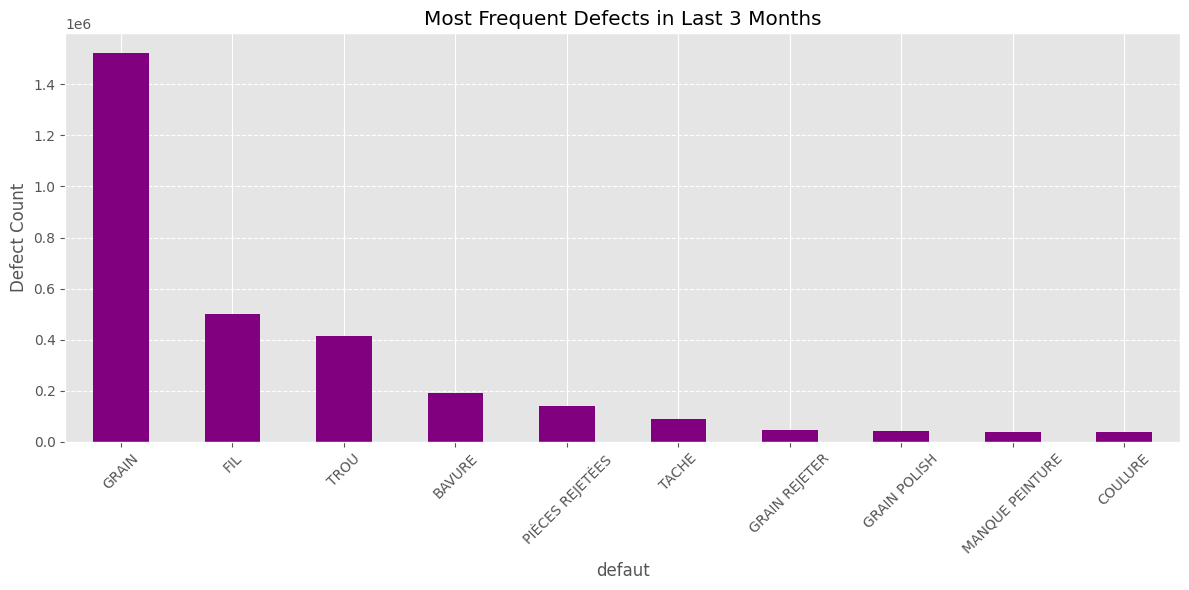


🔧 Recommendations for Better Forecasting:
1. Continue collecting data - most defects need more occurrence months
2. Focus on these defects that are closest to having enough data:
         Defect  Months_Recorded Last_Occurrence
ASPECT MOUCHETÉ                2         2025-02
 RETASSURE / DI                2         2025-02

3. Verify data collection process for defects that appear rarely
4. Consider merging similar defect categories if appropriate

📁 Analysis results saved to: /content/defect_analysis_20250521_103921


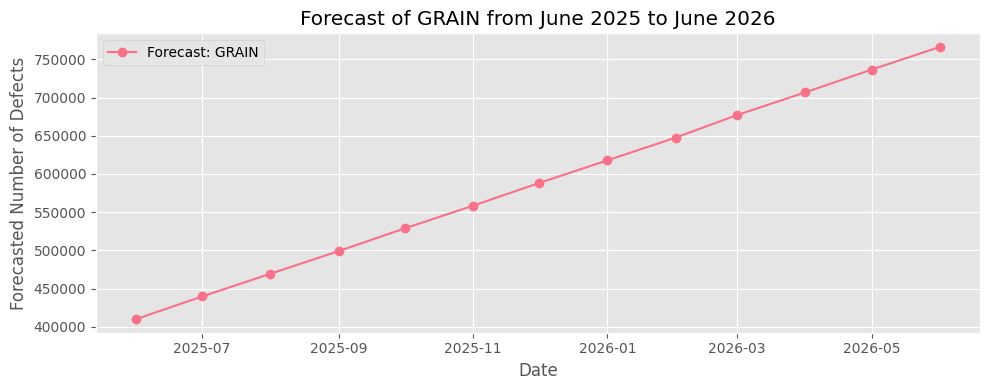

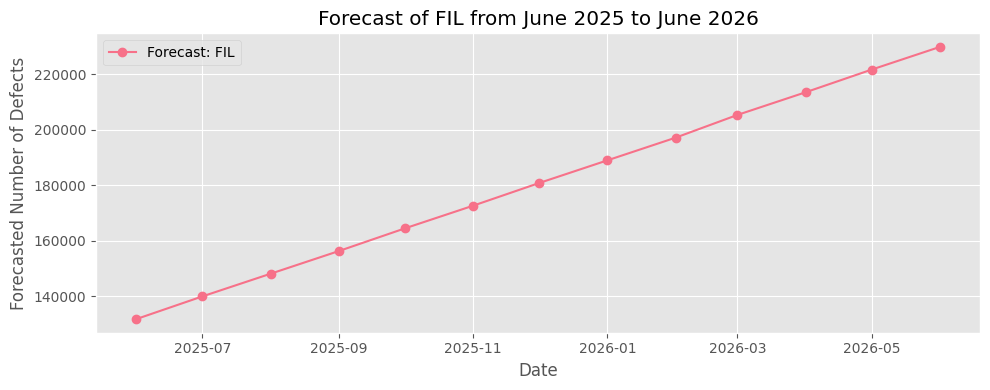

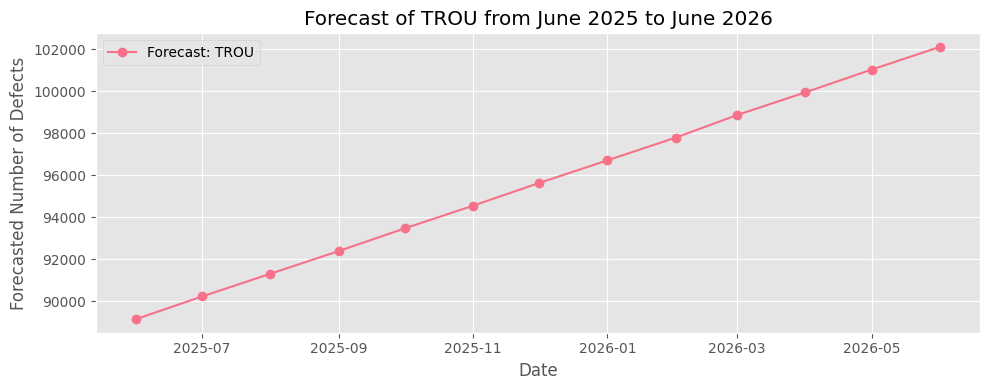

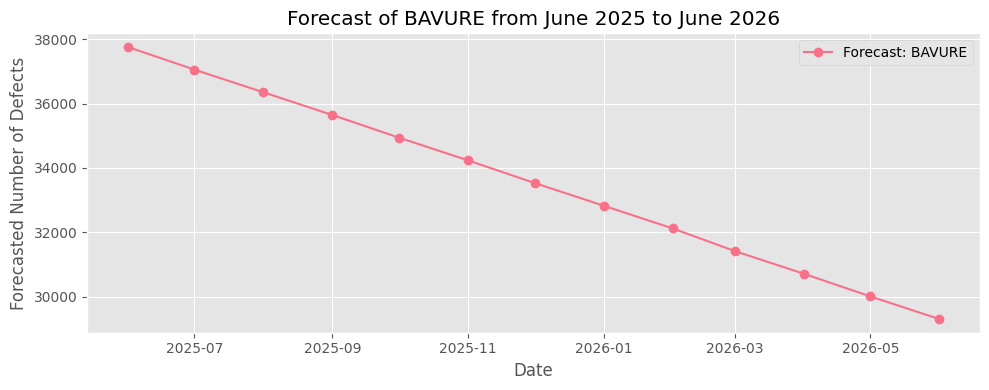

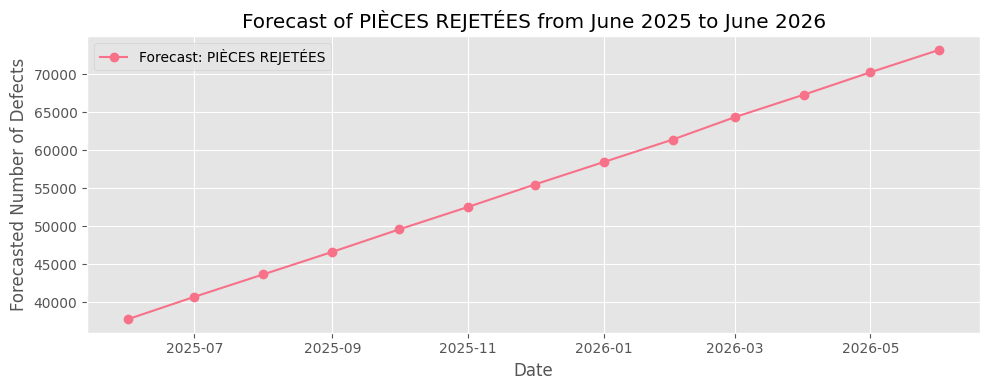

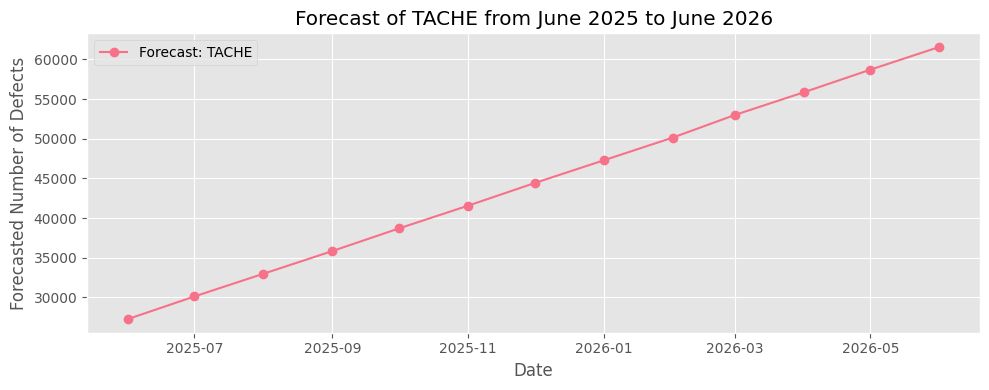

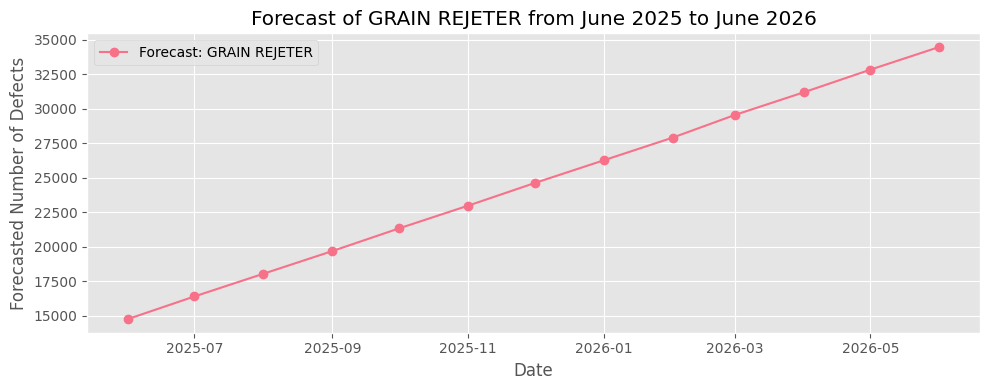

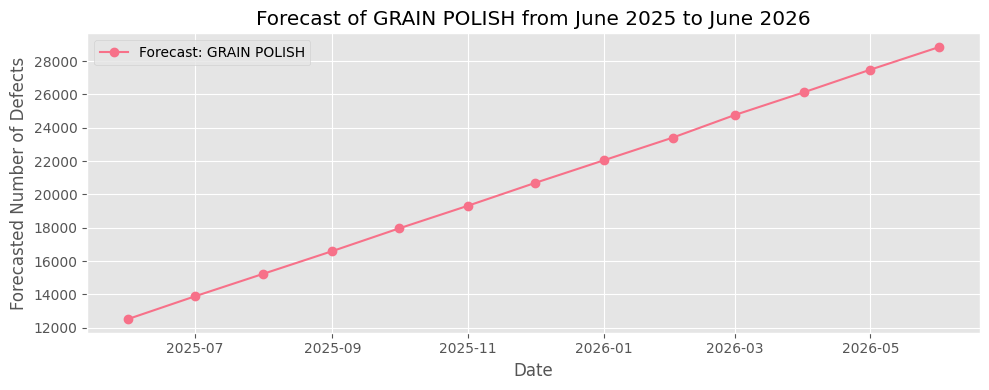

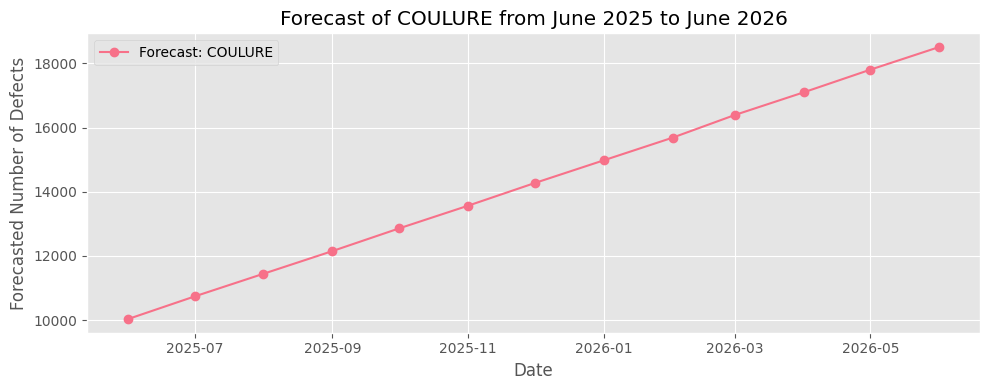

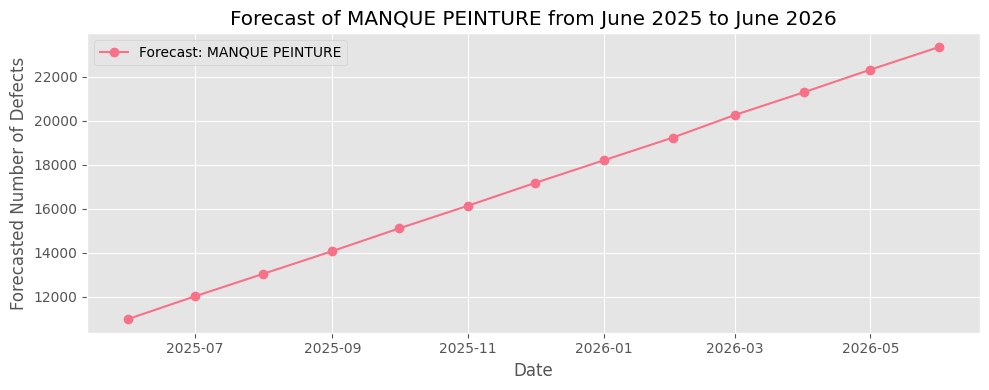

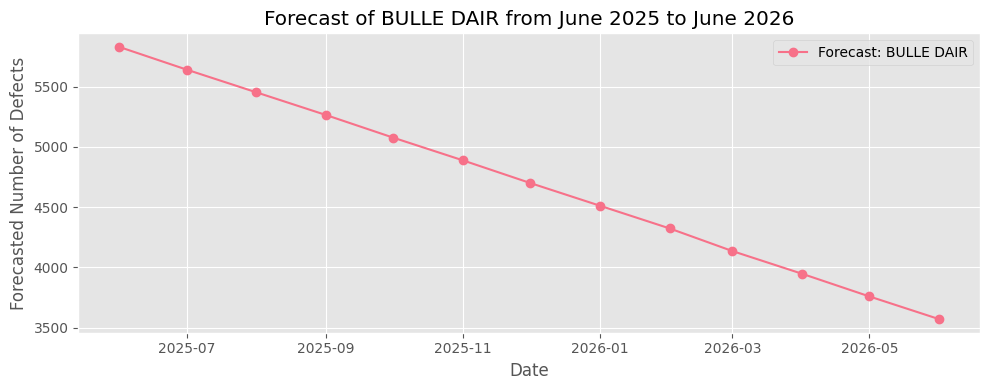

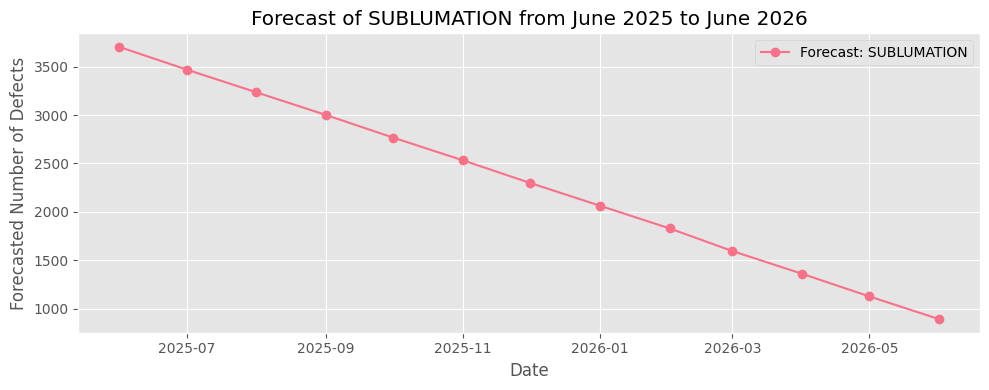

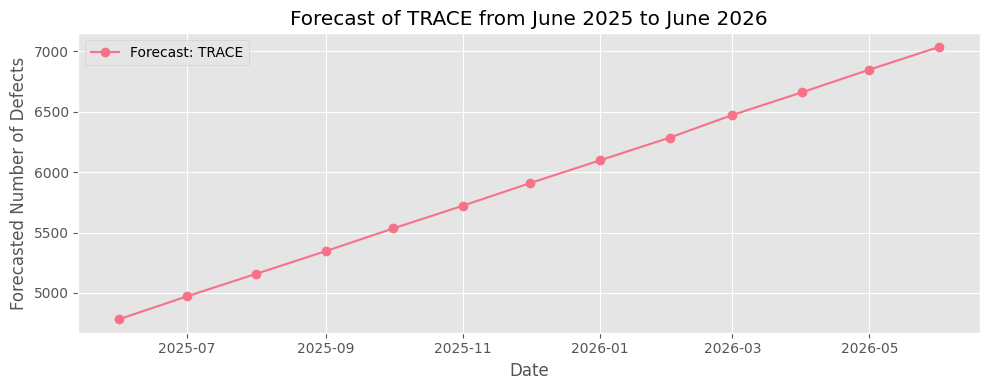

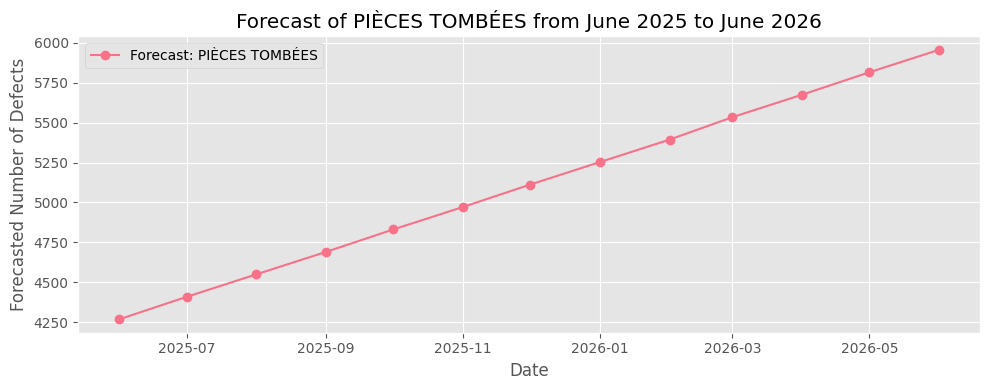

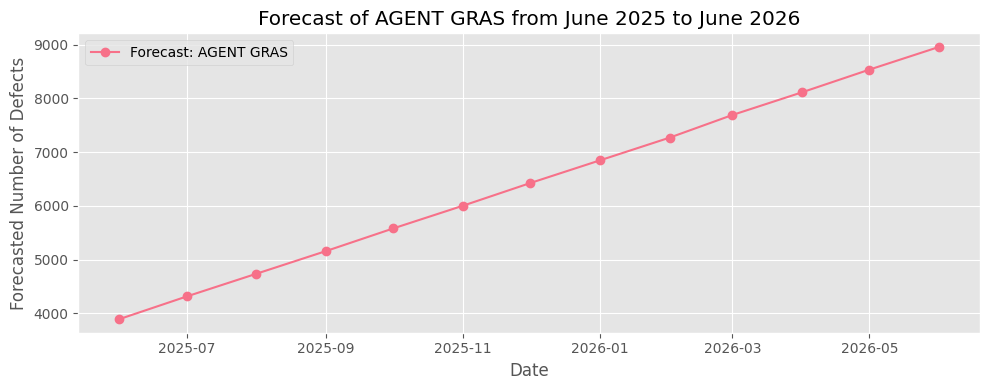

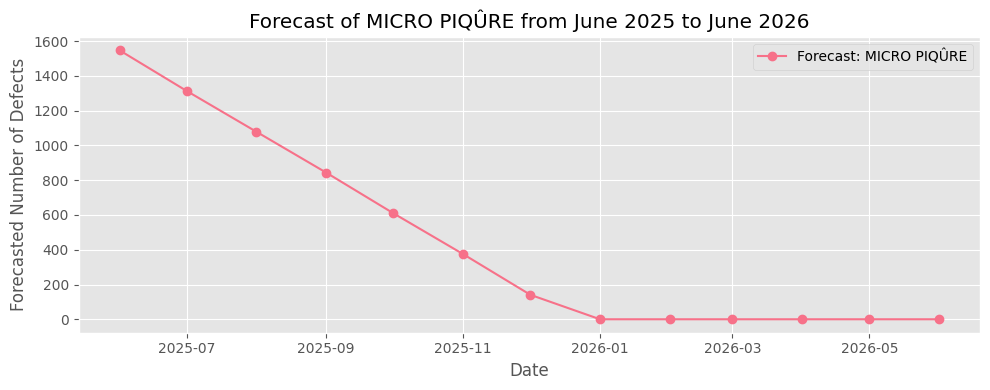

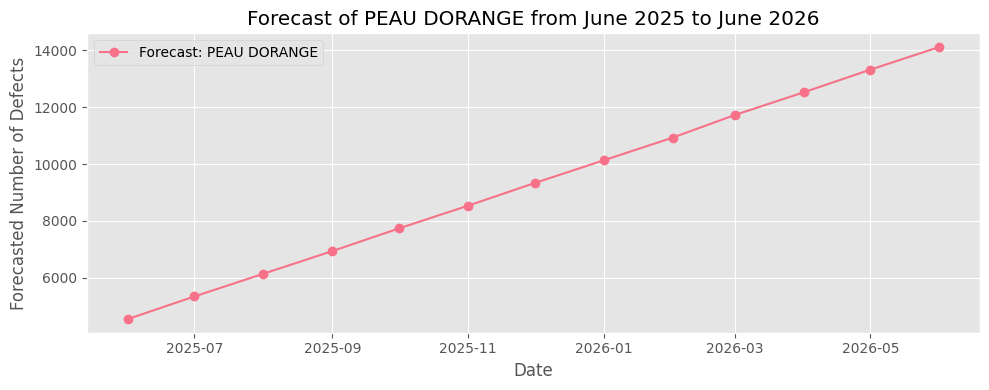

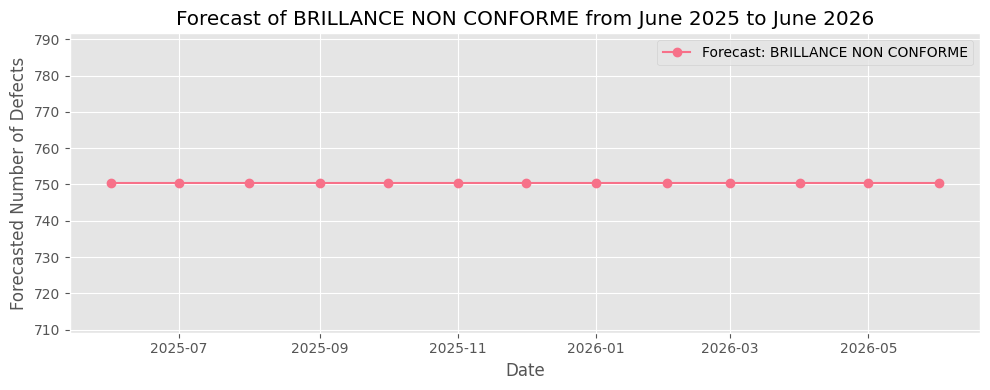

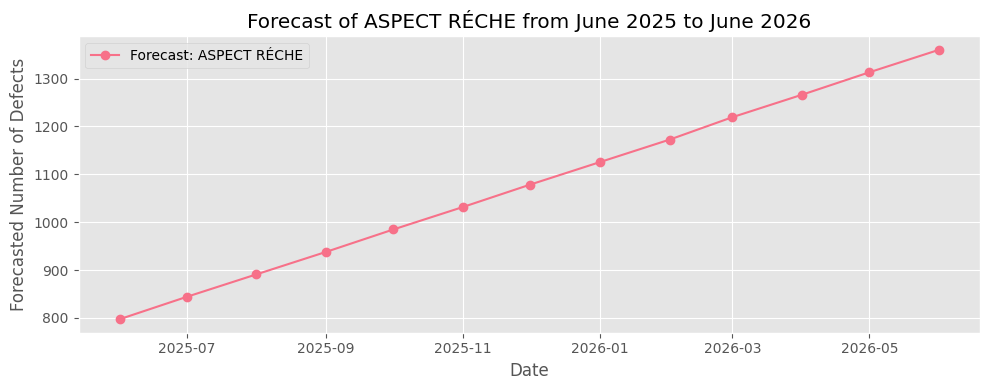

In [11]:
# 1. Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn plotly --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime, timedelta
import os

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 3. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    try:
        df = pd.read_csv(
            filepath,
            parse_dates=['date_defaut'],
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
            dtype={'nb_defauts': 'int32'}
        )

        df['defaut'] = (
            df['defaut']
            .str.strip()
            .str.upper()
            .str.replace(r'\s+', ' ', regex=True)
        )

        defect_name_mapping = {
            'CLIPS CASSE': 'CLIPS CASSE',
            'COULURE': 'COULURE',
            'MANQUE PEINTURE': 'MANQUE PEINTURE',
        }
        df['defaut'] = df['defaut'].map(defect_name_mapping).fillna(df['defaut'])

        df = (
            df.groupby(['date_defaut', 'defaut'])['nb_defauts']
            .sum()
            .unstack(fill_value=0)
            .stack()
            .reset_index(name='nb_defauts')
        )

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

try:
    df = load_and_preprocess_data('/content/defauts_par_piece.csv')
    print("✅ Data loaded successfully")
    print(f"Time range: {df['date_defaut'].min().date()} to {df['date_defaut'].max().date()}")
    print(f"{len(df['defaut'].unique())} unique defect types\n")
except Exception as e:
    print(f"❌ Critical error: {e}")
    raise

# 4. Data Analysis
def analyze_defect_frequency(df):
    monthly_pivot = (
        df.set_index('date_defaut')
        .groupby([pd.Grouper(freq='MS'), 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
    )

    defect_stats = []
    for defect in monthly_pivot.columns:
        defect_series = monthly_pivot[defect]
        active_months = defect_series[defect_series > 0]
        defect_stats.append({
            'Defect': defect,
            'Total': defect_series.sum(),
            'Months_Recorded': len(active_months),
            'First_Occurrence': active_months.index.min().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Last_Occurrence': active_months.index.max().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Average_Per_Month': active_months.mean() if len(active_months) > 0 else 0,
            'Suitable_For_Forecast': 'Yes' if len(active_months) >= 3 else 'No'
        })

    stats_df = pd.DataFrame(defect_stats).sort_values('Total', ascending=False)

    suitable_defects = stats_df[stats_df['Suitable_For_Forecast'] == 'Yes']
    print(f"🔍 Analysis Results:")
    print(f"- Total defects: {len(stats_df)}")
    print(f"- Defects with sufficient data (≥3 months): {len(suitable_defects)}")
    print(f"- Defects needing more data: {len(stats_df) - len(suitable_defects)}\n")

    plt.figure(figsize=(12, 6))
    stats_df['Months_Recorded'].hist(bins=20, color='teal')
    plt.axvline(x=3, color='red', linestyle='--', label='Minimum for Forecasting')
    plt.title('Distribution of Defect Occurrence Frequency')
    plt.xlabel('Number of Months with Occurrences')
    plt.ylabel('Number of Defect Types')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

    return stats_df

stats_df = analyze_defect_frequency(df)

# 5. Alternative Analysis
def perform_alternative_analysis(df, stats_df):
    print("📊 Alternative Analysis Approaches:")
    print("1. Defect Concentration Analysis")
    print("2. Monthly Trend Analysis")
    print("3. Defect Co-occurrence Patterns\n")

    top_defects = stats_df.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_defects, x='Total', y='Defect', palette='viridis')
    plt.title('Top 10 Defects by Total Occurrences')
    plt.xlabel('Total Defects Recorded')
    plt.ylabel('Defect Type')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='MS'))['nb_defauts'].sum()
    plt.figure(figsize=(12, 6))
    monthly_totals.plot(marker='o')
    plt.title('Total Defects Over Time')
    plt.ylabel('Defect Count')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

    recent_defects = df[df['date_defaut'] >= (df['date_defaut'].max() - pd.DateOffset(months=3))]
    recent_counts = recent_defects.groupby('defaut')['nb_defauts'].sum().sort_values(ascending=False)

    if not recent_counts.empty:
        plt.figure(figsize=(12, 6))
        recent_counts.head(10).plot(kind='bar', color='purple')
        plt.title('Most Frequent Defects in Last 3 Months')
        plt.ylabel('Defect Count')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No defect data in the last 3 months")

perform_alternative_analysis(df, stats_df)

# 6. Recommendations
def provide_recommendations(stats_df):
    print("\n🔧 Recommendations for Better Forecasting:")
    print("1. Continue collecting data - most defects need more occurrence months")
    print("2. Focus on these defects that are closest to having enough data:")

    promising_defects = stats_df[(stats_df['Months_Recorded'] >= 2) & (stats_df['Months_Recorded'] < 3)]

    if not promising_defects.empty:
        print(promising_defects[['Defect', 'Months_Recorded', 'Last_Occurrence']].to_string(index=False))
    else:
        print("(No defects currently with 2-3 months of data)")

    print("\n3. Verify data collection process for defects that appear rarely")
    print("4. Consider merging similar defect categories if appropriate")

provide_recommendations(stats_df)

# 7. Save results
def save_analysis_results(stats_df, path='/content'):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f"{path}/defect_analysis_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    stats_df.to_csv(f"{save_dir}/defect_stats.csv", index=False)
    print(f"\n📁 Analysis results saved to: {save_dir}")

save_analysis_results(stats_df)

# 8. Forecasting
def forecast_defects(df, stats_df):
    forecastable_defects = stats_df[stats_df['Months_Recorded'] >= 3]['Defect'].tolist()

    if not forecastable_defects:
        print("⚠️ No defects with enough data for forecasting.")
        return pd.DataFrame()

    future_months = pd.date_range(start='2025-06-01', end='2026-06-01', freq='MS')

    forecasts = []
    for defect in forecastable_defects:
        defect_data = (
            df[df['defaut'] == defect]
            .groupby(pd.Grouper(key='date_defaut', freq='MS'))['nb_defauts']
            .sum()
            .reset_index()
        )

        X = np.arange(len(defect_data)).reshape(-1, 1)
        y = defect_data['nb_defauts'].values

        model = LinearRegression()
        model.fit(X, y)

        future_X = np.arange(len(defect_data), len(defect_data) + len(future_months)).reshape(-1, 1)
        future_preds = model.predict(future_X)
        future_preds = np.maximum(0, future_preds)

        forecast_df = pd.DataFrame({
            'date': future_months,
            'defaut': defect,
            'forecast_nb_defauts': future_preds
        })

        forecasts.append(forecast_df)

    return pd.concat(forecasts, ignore_index=True)

# 9. Run Forecast and Plot
forecast_df = forecast_defects(df, stats_df)

if not forecast_df.empty:
    for defect in forecast_df['defaut'].unique():
        sub_df = forecast_df[forecast_df['defaut'] == defect]
        plt.figure(figsize=(10, 4))
        plt.plot(sub_df['date'], sub_df['forecast_nb_defauts'], marker='o', label=f"Forecast: {defect}")
        plt.title(f"Forecast of {defect} from June 2025 to June 2026")
        plt.xlabel("Date")
        plt.ylabel("Forecasted Number of Defects")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("📉 No forecasts generated.")



🔍 Total defects: 28
✔️ Defects suitable for forecasting (≥6 months): 0
⚠️ Defects needing more data: 28


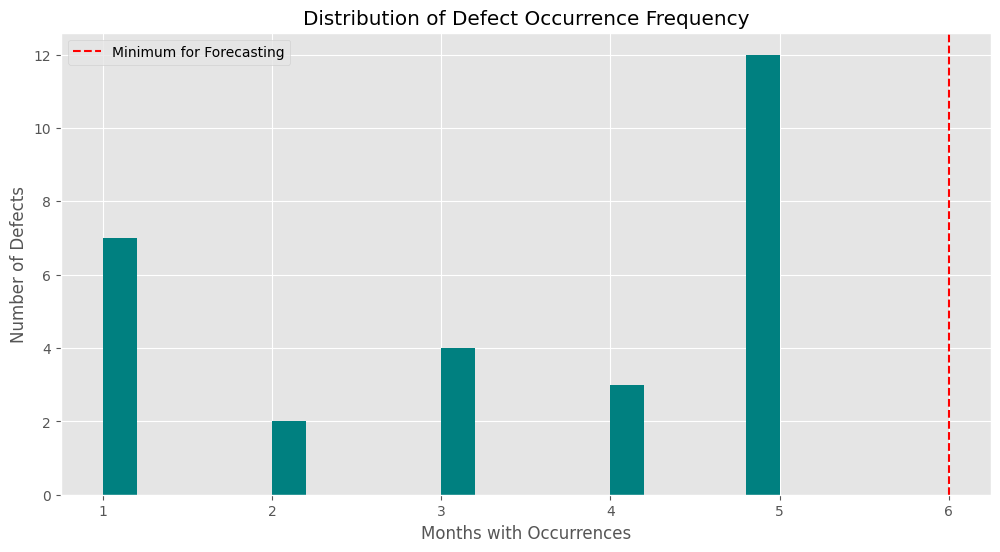

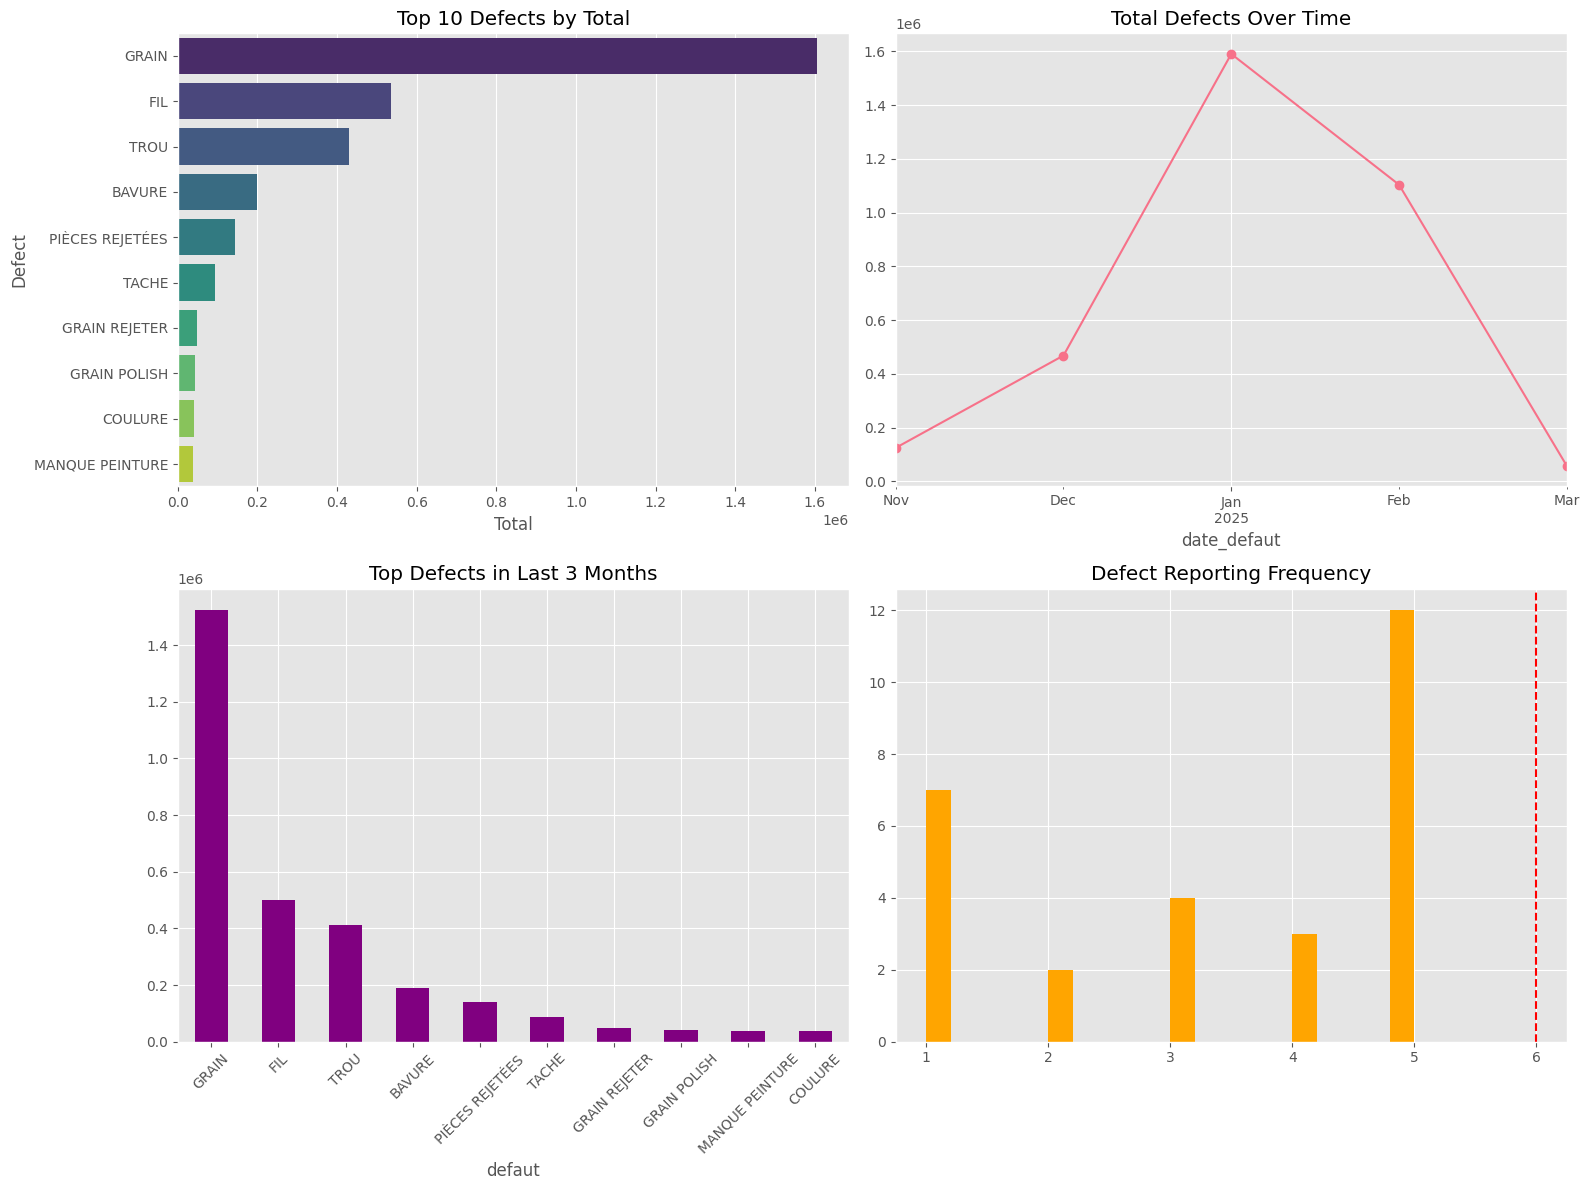


🔧 Data Quality Recommendations:
➡️ Defects close to being forecastable (3-5 months):
                Defect  Months_Recorded Last_Occurrence
                 GRAIN                5         2025-03
                   FIL                5         2025-03
                  TROU                5         2025-03
                BAVURE                5         2025-03
       PIÈCES REJETÉES                5         2025-03
                 TACHE                5         2025-03
         GRAIN REJETER                4         2025-02
          GRAIN POLISH                5         2025-03
               COULURE                5         2025-03
       MANQUE PEINTURE                5         2025-03
            BULLE DAIR                4         2025-02
           SUBLUMATION                3         2025-02
                 TRACE                5         2025-03
        PIÈCES TOMBÉES                5         2025-03
            AGENT GRAS                5         2025-03
          MICRO PI

In [16]:
# 1. Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn plotly --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
import os

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 3. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    try:
        df = pd.read_csv(
            filepath,
            parse_dates=['date_defaut'],
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
            dtype={'nb_defauts': 'int32'}
        )

        df['defaut'] = (
            df['defaut']
            .str.strip()
            .str.upper()
            .str.replace(r'\s+', ' ', regex=True)
        )

        defect_name_mapping = {
            'CLIPS CASSE': 'CLIPS CASSE',
            'COULURE': 'COULURE',
            'MANQUE PEINTURE': 'MANQUE PEINTURE',
        }
        df['defaut'] = df['defaut'].map(defect_name_mapping).fillna(df['defaut'])

        df = (
            df.groupby(['date_defaut', 'defaut'])['nb_defauts']
            .sum()
            .unstack(fill_value=0)
            .stack()
            .reset_index(name='nb_defauts')
        )
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load data
df = load_and_preprocess_data('/content/defauts_par_piece.csv')

# 4. Data Analysis
def analyze_defect_frequency(df):
    monthly_pivot = (
        df.set_index('date_defaut')
        .groupby([pd.Grouper(freq='M'), 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
    )

    defect_stats = []
    for defect in monthly_pivot.columns:
        series = monthly_pivot[defect]
        active_months = series[series > 0]
        defect_stats.append({
            'Defect': defect,
            'Total': series.sum(),
            'Months_Recorded': len(active_months),
            'First_Occurrence': active_months.index.min().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Last_Occurrence': active_months.index.max().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Average_Per_Month': active_months.mean() if len(active_months) > 0 else 0,
            'Suitable_For_Forecast': 'Yes' if len(active_months) >= 6 else 'No'
        })

    stats_df = pd.DataFrame(defect_stats).sort_values('Total', ascending=False)

    suitable_defects = stats_df[stats_df['Suitable_For_Forecast'] == 'Yes']
    print(f"\n🔍 Total defects: {len(stats_df)}")
    print(f"✔️ Defects suitable for forecasting (≥6 months): {len(suitable_defects)}")
    print(f"⚠️ Defects needing more data: {len(stats_df) - len(suitable_defects)}")

    # Plot histogram
    plt.figure(figsize=(12, 6))
    stats_df['Months_Recorded'].hist(bins=20, color='teal')
    plt.axvline(x=6, color='red', linestyle='--', label='Minimum for Forecasting')
    plt.title('Distribution of Defect Occurrence Frequency')
    plt.xlabel('Months with Occurrences')
    plt.ylabel('Number of Defects')
    plt.legend()
    plt.grid(True)
    plt.show()

    return stats_df

stats_df = analyze_defect_frequency(df)

# 5. Alternative Analysis in Single Figure
def combined_visuals(df, stats_df):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Top Defects
    top_defects = stats_df.head(10)
    sns.barplot(data=top_defects, x='Total', y='Defect', ax=axs[0, 0], palette='viridis')
    axs[0, 0].set_title('Top 10 Defects by Total')
    axs[0, 0].grid(True, axis='x')

    # Monthly Trends
    monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='M'))['nb_defauts'].sum()
    monthly_totals.plot(marker='o', ax=axs[0, 1])
    axs[0, 1].set_title('Total Defects Over Time')
    axs[0, 1].grid(True)

    # Recent Defects
    recent_df = df[df['date_defaut'] >= (df['date_defaut'].max() - pd.DateOffset(months=3))]
    recent_counts = recent_df.groupby('defaut')['nb_defauts'].sum().sort_values(ascending=False)
    recent_counts.head(10).plot(kind='bar', ax=axs[1, 0], color='purple')
    axs[1, 0].set_title('Top Defects in Last 3 Months')
    axs[1, 0].tick_params(axis='x', rotation=45)
    axs[1, 0].grid(True)

    # Histogram of Active Months
    stats_df['Months_Recorded'].hist(bins=20, color='orange', ax=axs[1, 1])
    axs[1, 1].axvline(x=6, color='red', linestyle='--')
    axs[1, 1].set_title('Defect Reporting Frequency')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

combined_visuals(df, stats_df)

# 6. Recommendations
def provide_recommendations(stats_df):
    print("\n🔧 Data Quality Recommendations:")
    promising = stats_df[(stats_df['Months_Recorded'] >= 3) & (stats_df['Months_Recorded'] < 6)]
    if not promising.empty:
        print("➡️ Defects close to being forecastable (3-5 months):")
        print(promising[['Defect', 'Months_Recorded', 'Last_Occurrence']].to_string(index=False))
    else:
        print("✅ No defects in the 3-5 month range.")
    print("📌 Merge similar categories or ensure consistent data entry if some names are near-duplicates.")

provide_recommendations(stats_df)

# 7. Forecasting (for June 2025 – June 2026)
def forecast_defects(df, stats_df):
    forecast_results = []

    forecastable = stats_df[stats_df['Suitable_For_Forecast'] == 'Yes']['Defect']
    if forecastable.empty:
        print("⚠️ No defect types have enough data (≥6 months) to forecast.")
        return pd.DataFrame()

    for defect in forecastable:
        data = df[df['defaut'] == defect]
        monthly = (
            data.set_index('date_defaut')
            .resample('M')['nb_defauts']
            .sum()
            .fillna(0)
            .reset_index()
        )
        monthly['month_num'] = np.arange(len(monthly))
        model = LinearRegression().fit(monthly[['month_num']], monthly['nb_defauts'])

        future_months = pd.date_range(start='2025-06-01', end='2026-06-01', freq='MS')
        future_nums = np.arange(len(monthly), len(monthly) + len(future_months))
        predictions = model.predict(future_nums.reshape(-1, 1))

        forecast_df = pd.DataFrame({
            'date': future_months,
            'defaut': defect,
            'predicted_defauts': np.maximum(0, predictions.round())
        })

        forecast_results.append(forecast_df)

    result = pd.concat(forecast_results, ignore_index=True)
    print(f"📈 Forecasted {len(forecastable)} defect types.")
    return result

forecast_df = forecast_defects(df, stats_df)

# Optional: Show forecast for top 3 defects
if not forecast_df.empty:
    top_3 = forecast_df['defaut'].value_counts().head(3).index
    for defect in top_3:
        defect_data = forecast_df[forecast_df['defaut'] == defect]
        plt.plot(defect_data['date'], defect_data['predicted_defauts'], label=defect)

    plt.title("Forecast for Top 3 Defects (Jun 2025 - Jun 2026)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Defects")
    plt.legend()
    plt.grid(True)
    plt.show()

# 8. Save Results
def save_analysis_results(stats_df, forecast_df, path='/content'):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f"{path}/defect_analysis_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)

    stats_df.to_csv(f"{save_dir}/defect_stats.csv", index=False)
    if not forecast_df.empty:
        forecast_df.to_csv(f"{save_dir}/forecast.csv", index=False)

    print(f"\n📁 Results saved in: {save_dir}")

save_analysis_results(stats_df, forecast_df)


✅ Data loaded successfully
Time range: 2024-11-18 to 2025-03-05
28 unique defect types

🔍 Analysis Results:
- Total defects: 28
- Defects with sufficient data (≥3 months): 19
- Defects needing more data: 9



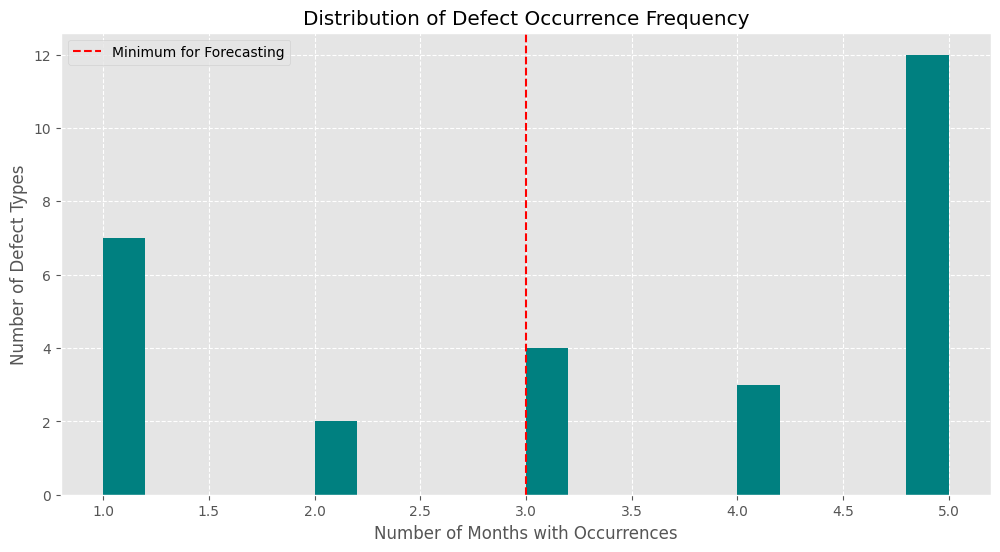

📊 Alternative Analysis Approaches:
1. Defect Concentration Analysis
2. Monthly Trend Analysis
3. Defect Co-occurrence Patterns



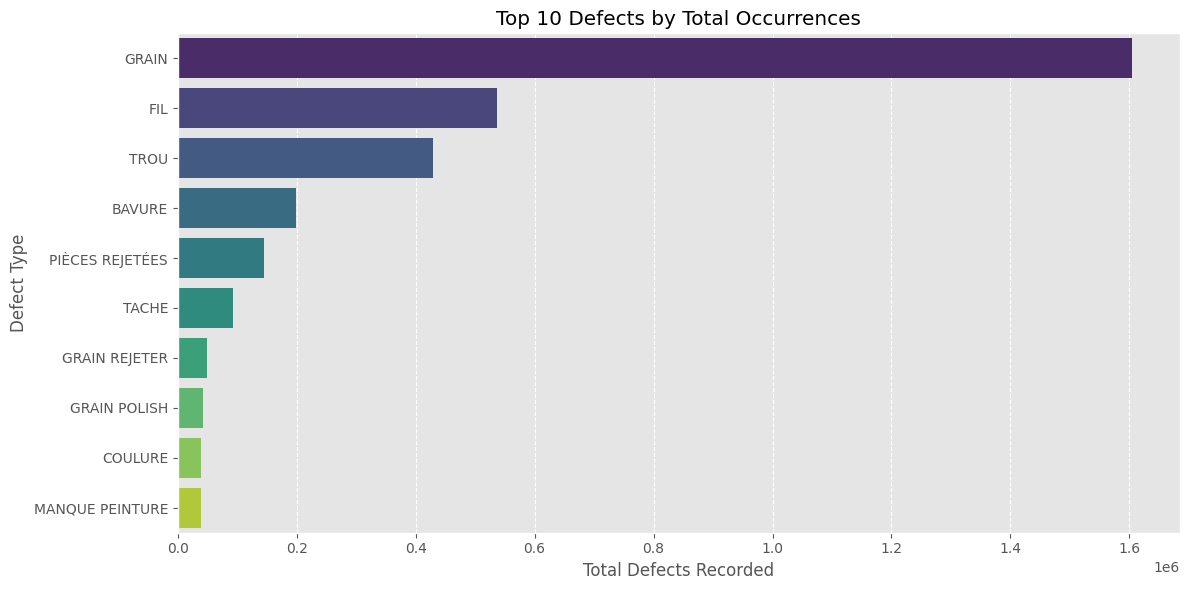

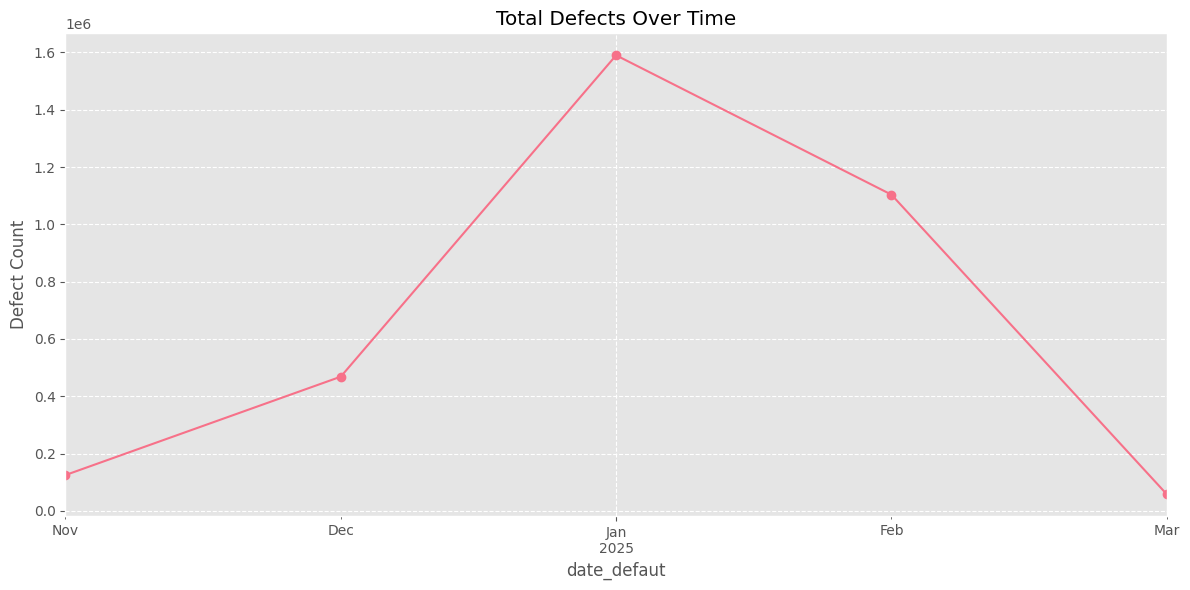

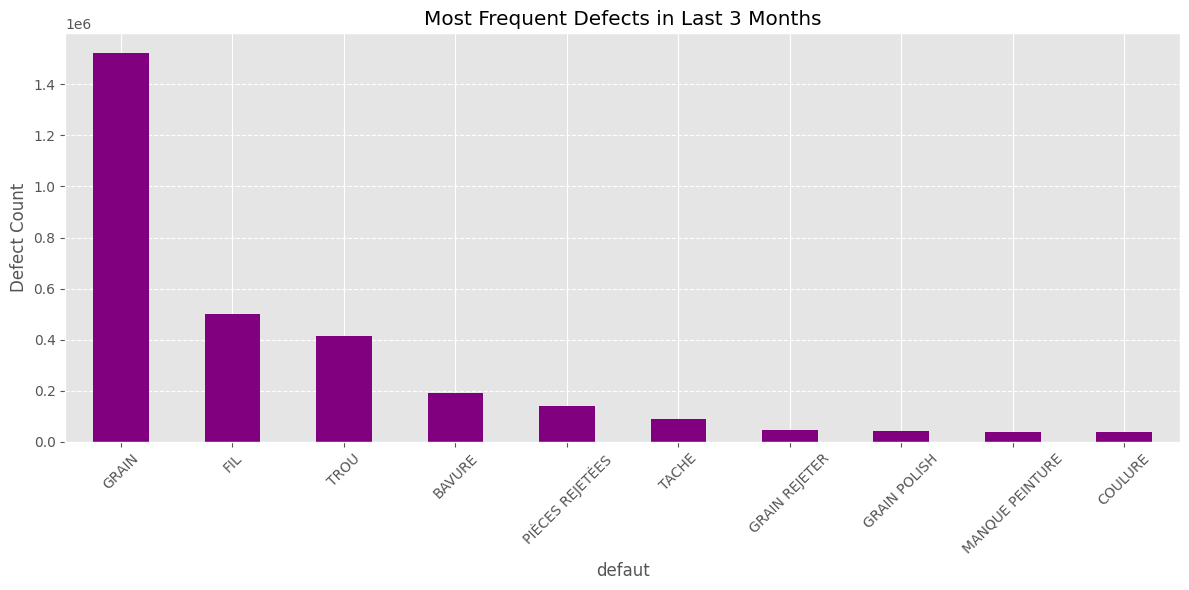


🔧 Recommendations for Better Forecasting:
1. Continue collecting data - most defects need more occurrence months
2. Focus on these defects that are closest to having enough data:
         Defect  Months_Recorded Last_Occurrence
ASPECT MOUCHETÉ                2         2025-02
 RETASSURE / DI                2         2025-02

3. Verify data collection process for defects that appear rarely
4. Consider merging similar defect categories if appropriate

📁 Analysis results saved to: /content/defect_analysis_20250521_105801


In [20]:
# 1. Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn plotly --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime, timedelta
import os

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 3. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    try:
        df = pd.read_csv(
            filepath,
            parse_dates=['date_defaut'],
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
            dtype={'nb_defauts': 'int32'}
        )

        df['defaut'] = (
            df['defaut']
            .str.strip()
            .str.upper()
            .str.replace(r'\s+', ' ', regex=True)
        )

        defect_name_mapping = {
            'CLIPS CASSE': 'CLIPS CASSE',
            'COULURE': 'COULURE',
            'MANQUE PEINTURE': 'MANQUE PEINTURE',
        }
        df['defaut'] = df['defaut'].map(defect_name_mapping).fillna(df['defaut'])

        df = (
            df.groupby(['date_defaut', 'defaut'])['nb_defauts']
            .sum()
            .unstack(fill_value=0)
            .stack()
            .reset_index(name='nb_defauts')
        )

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

try:
    df = load_and_preprocess_data('/content/defauts_par_piece.csv')
    print("✅ Data loaded successfully")
    print(f"Time range: {df['date_defaut'].min().date()} to {df['date_defaut'].max().date()}")
    print(f"{len(df['defaut'].unique())} unique defect types\n")
except Exception as e:
    print(f"❌ Critical error: {e}")
    raise

# 4. Data Analysis
def analyze_defect_frequency(df):
    monthly_pivot = (
        df.set_index('date_defaut')
        .groupby([pd.Grouper(freq='MS'), 'defaut'])['nb_defauts']
        .sum()
        .unstack(fill_value=0)
    )

    defect_stats = []
    for defect in monthly_pivot.columns:
        defect_series = monthly_pivot[defect]
        active_months = defect_series[defect_series > 0]
        defect_stats.append({
            'Defect': defect,
            'Total': defect_series.sum(),
            'Months_Recorded': len(active_months),
            'First_Occurrence': active_months.index.min().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Last_Occurrence': active_months.index.max().strftime('%Y-%m') if len(active_months) > 0 else 'Never',
            'Average_Per_Month': active_months.mean() if len(active_months) > 0 else 0,
            'Suitable_For_Forecast': 'Yes' if len(active_months) >= 3 else 'No'
        })

    stats_df = pd.DataFrame(defect_stats).sort_values('Total', ascending=False)

    suitable_defects = stats_df[stats_df['Suitable_For_Forecast'] == 'Yes']
    print(f"🔍 Analysis Results:")
    print(f"- Total defects: {len(stats_df)}")
    print(f"- Defects with sufficient data (≥3 months): {len(suitable_defects)}")
    print(f"- Defects needing more data: {len(stats_df) - len(suitable_defects)}\n")

    plt.figure(figsize=(12, 6))
    stats_df['Months_Recorded'].hist(bins=20, color='teal')
    plt.axvline(x=3, color='red', linestyle='--', label='Minimum for Forecasting')
    plt.title('Distribution of Defect Occurrence Frequency')
    plt.xlabel('Number of Months with Occurrences')
    plt.ylabel('Number of Defect Types')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

    return stats_df

stats_df = analyze_defect_frequency(df)

# 5. Alternative Analysis
def perform_alternative_analysis(df, stats_df):
    print("📊 Alternative Analysis Approaches:")
    print("1. Defect Concentration Analysis")
    print("2. Monthly Trend Analysis")
    print("3. Defect Co-occurrence Patterns\n")

    top_defects = stats_df.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_defects, x='Total', y='Defect', palette='viridis')
    plt.title('Top 10 Defects by Total Occurrences')
    plt.xlabel('Total Defects Recorded')
    plt.ylabel('Defect Type')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    monthly_totals = df.groupby(pd.Grouper(key='date_defaut', freq='MS'))['nb_defauts'].sum()
    plt.figure(figsize=(12, 6))
    monthly_totals.plot(marker='o')
    plt.title('Total Defects Over Time')
    plt.ylabel('Defect Count')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

    recent_defects = df[df['date_defaut'] >= (df['date_defaut'].max() - pd.DateOffset(months=3))]
    recent_counts = recent_defects.groupby('defaut')['nb_defauts'].sum().sort_values(ascending=False)

    if not recent_counts.empty:
        plt.figure(figsize=(12, 6))
        recent_counts.head(10).plot(kind='bar', color='purple')
        plt.title('Most Frequent Defects in Last 3 Months')
        plt.ylabel('Defect Count')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No defect data in the last 3 months")

perform_alternative_analysis(df, stats_df)

# 6. Recommendations
def provide_recommendations(stats_df):
    print("\n🔧 Recommendations for Better Forecasting:")
    print("1. Continue collecting data - most defects need more occurrence months")
    print("2. Focus on these defects that are closest to having enough data:")

    promising_defects = stats_df[(stats_df['Months_Recorded'] >= 2) & (stats_df['Months_Recorded'] < 3)]

    if not promising_defects.empty:
        print(promising_defects[['Defect', 'Months_Recorded', 'Last_Occurrence']].to_string(index=False))
    else:
        print("(No defects currently with 2-3 months of data)")

    print("\n3. Verify data collection process for defects that appear rarely")
    print("4. Consider merging similar defect categories if appropriate")

provide_recommendations(stats_df)

# 7. Save results
def save_analysis_results(stats_df, path='/content'):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = f"{path}/defect_analysis_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    stats_df.to_csv(f"{save_dir}/defect_stats.csv", index=False)
    print(f"\n📁 Analysis results saved to: {save_dir}")

save_analysis_results(stats_df)

# 8. Forecasting
def forecast_defects(df, stats_df):
    forecastable_defects = stats_df[stats_df['Months_Recorded'] >= 3]['Defect'].tolist()

    if not forecastable_defects:
        print("⚠️ No defects with enough data for forecasting.")
        return pd.DataFrame()

    future_months = pd.date_range(start='2025-06-01', end='2026-06-01', freq='MS')

    forecasts = []
    for defect in forecastable_defects:
        defect_data = (
            df[df['defaut'] == defect]
            .groupby(pd.Grouper(key='date_defaut', freq='MS'))['nb_defauts']
            .sum()
            .reset_index()
        )

        X = np.arange(len(defect_data)).reshape(-1, 1)
        y = defect_data['nb_defauts'].values

        model = LinearRegression()
        model.fit(X, y)

        future_X = np.arange(len(defect_data), len(defect_data) + len(future_months)).reshape(-1, 1)
        future_preds = model.predict(future_X)
        future_preds = np.maximum(0, future_preds)

        forecast_df = pd.DataFrame({
            'date': future_months,
            'defaut': defect,
            'forecast_nb_defauts': future_preds
        })

        forecasts.append(forecast_df)

    return pd.concat(forecasts, ignore_index=True)

# 9. Run Forecast and Plot (Modified Combined Visualization)
forecast_df = forecast_defects(df, stats_df)

if not forecast_df.empty:
    # Create interactive Plotly figure
    fig = px.line(forecast_df,
                  x='date',
                  y='forecast_nb_defauts',
                  color='defaut',
                  title='Combined Defect Forecasts (June 2025 - June 2026)',
                  labels={'forecast_nb_defauts': 'Forecasted Defects', 'date': 'Date'},
                  markers=True,
                  line_shape='linear')

    # Enhance layout
    fig.update_layout(
        hovermode='x unified',
        legend=dict(title='Defect Type',
                   orientation='h',
                   yanchor='bottom',
                   y=1.02,
                   xanchor='right',
                   x=1),
        xaxis=dict(title='Date', showgrid=True),
        yaxis=dict(title='Forecasted Defects', showgrid=True),
        template='plotly_white'
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

    # Optional: Save interactive plot
    fig.write_html("/content/combined_forecast.html")

else:
    print("📉 No forecasts generated.")

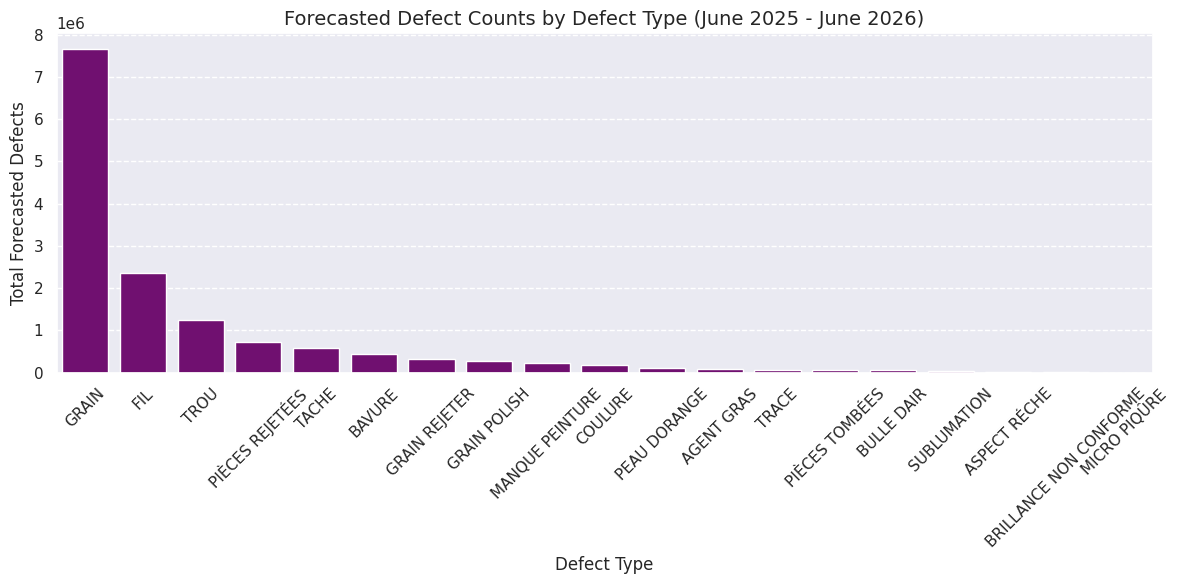

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set style similar to uploaded image
sns.set_theme(style='darkgrid')  # light gray grid background
plt.rcParams['figure.facecolor'] = 'white'

# Assume `forecast_df` is already created from previous forecasting step
# It should contain: ['date', 'defaut', 'forecast_nb_defauts']

# 1. Aggregate forecasted defect counts by defect type
total_forecast = (
    forecast_df.groupby('defaut')['forecast_nb_defauts']
    .sum()
    .reset_index()
    .rename(columns={'forecast_nb_defauts': 'total_forecast'})
)

# 2. Sort in descending order
total_forecast = total_forecast.sort_values(by='total_forecast', ascending=False)

# 3. Plot bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=total_forecast,
    x='defaut',
    y='total_forecast',
    color='purple'
)

# 4. Customize chart
plt.title('Forecasted Defect Counts by Defect Type (June 2025 - June 2026)', fontsize=14)
plt.xlabel('Defect Type')
plt.ylabel('Total Forecasted Defects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')

# 5. Show plot
plt.show()
